In [2]:
import SimpleITK as sitk # https://simpleelastix.readthedocs.io/

import numpy as np
import pandas as pd
import scipy as sp
import scipy.interpolate
from scipy import ndimage
from scipy.spatial.transform import Rotation as R

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import skimage
import skimage.io
import skimage.transform
import skimage.exposure
import skimage.filters
import skimage.morphology

import tifffile
import nrrd

import math, re, os, shutil, ast, sys, time, random, gc, pickle, time, copy

In [3]:
# definitions

# overlay to images to green and magenta
def imageoverlay(imG, imM):
    assert imG.shape == imM.shape
    output = np.zeros(imG.shape + (3,))
    g = skimage.util.img_as_float(imG)
    m = skimage.util.img_as_float(imM)
    output[:,:,0] = m 
    output[:,:,2] = m
    output[:,:,1] = g
    return output

# makes result image have values from 0-1 so it is acceptable to skimage
def scale_result(im):
    return (im - np.min(im))/np.ptp(im)

# adjust the contrast and brightness using percentage of cumulative distribution
def imagescPercent(im, percentlow, percenthigh):
    c , bins = skimage.exposure.cumulative_distribution(im)
    intlow = bins[np.argmin(np.abs(c - percentlow))].astype(im.dtype)
    inthigh = bins[np.argmin(np.abs(c - percenthigh))].astype(im.dtype)
    return skimage.exposure.rescale_intensity(im, in_range = (intlow, inthigh))

def border_transparency(im, RGBval = [1,1,1]):
    im = im/np.amax(im)
    alphas = im > np.amax(im)/5 # the input should have been a single values image anyways...
    rgb = im[:,:,None] * np.array(RGBval)
    return np.concatenate((rgb, alphas[:,:,None]), axis = 2)

# adjust the contrast and brightness using percentage of cumulative distribution
def adjustBC(im, percentlow, percenthigh):
    c , bins = skimage.exposure.cumulative_distribution(im)
    intlow = bins[np.argmin(np.abs(c - percentlow))].astype(im.dtype)
    inthigh = bins[np.argmin(np.abs(c - percenthigh))].astype(im.dtype)
    return skimage.exposure.rescale_intensity(im, in_range = (intlow, inthigh))

# rescale an image size and return uint16
# the preserve range thing here is weird, can it be set to true without the conversion?
def image_rescale(im, factor):
    return skimage.util.img_as_uint(skimage.transform.rescale(im, factor, preserve_range = False))

# fit a list of different sized images into one array
def image_list_to_array(ims):
    size_max = np.amax(np.array([im.shape for im in ims]), axis = 0)
    output = np.zeros([len(ims),size_max[0],size_max[1]], dtype = ims[0].dtype)
    for i,im in enumerate(ims):
        cols, rows = im.shape
        output[i,0:cols,0:rows] = im
    return output

# make some sort of funtion to pre process the data for registration

# gaussian blur
def blur(im, rad = 15):
    return skimage.filters.gaussian(im, rad)

def preprocess(im, thresh_factor = 1, rad = 15):
    edge = skimage.filters.sobel(im)
    thresh = skimage.filters.threshold_otsu(edge)
    return skimage.filters.gaussian(edge > thresh, rad)

def preprocess(im, thresh_factor = 1, rad = 5):
    edge = skimage.filters.sobel(im)
    thresh = skimage.filters.threshold_otsu(edge)
    sel = skimage.morphology.disk(rad)
    output =  blur(skimage.morphology.binary_closing(edge > (thresh * thresh_factor), sel))
    return np.clip(output,0,1)

# binarize an image after blurring and choosing a threshold
def binarize(im, blur_size = 1, thresh_factor = 0.1):
    blurred = blur(im, rad = blur_size) 
    thresh = thresh_factor * skimage.filters.threshold_otsu(blurred)
    return blurred > thresh

def plot_histogram(im, bins = 256, irange = (0,65535)):
    histogram, bin_edges = np.histogram(im, bins=bins, range=irange)
    plt.plot(bin_edges[0:-1], histogram)
    plt.ylim(0,np.amax(histogram[1:]))
    plt.show()

def find_corner(im, area_thresh = 100):
    imB = binarize(im)
    labels = skimage.measure.label(imB)
    rprops = skimage.measure.regionprops(labels)
    rprops = [p for p in rprops if p.area > area_thresh]
    rmin, cmin = np.amin(np.array([p.bbox for p in rprops]), axis = 0)[[0,1]]
    rmax, cmax = np.amax(np.array([p.bbox for p in rprops]), axis = 0)[[2,3]]
    return rmin, cmin, rmax, cmax

# crop an image using the find_corner function
def crop_image(im):
    bbox = find_corner(im)
    return im[bbox[0]:bbox[2], bbox[1]:bbox[3]]

# this will make a test grid the same size as the image
# may be useful to judge how disruptive the transformation is
def make_grid_image(im, grid_size = 220, pix_size = 50):
    dxy = int(grid_size / pix_size)
    output = np.zeros(im.shape)
    for r in range(0, im.shape[0], dxy):
        output[r] = 1
    for c in range(0, im.shape[1], dxy):
        output[:,c] = 1
    return output

def make_grid_image_3D(im, grid_size = 220, pix_size = 50):
    dxy = int(grid_size / pix_size)
    output = np.zeros(im.shape)
    for s in range(0, im.shape[0], dxy):
        output[s] = 1
    for r in range(0, im.shape[1], dxy):
        output[:,r] = 1
    for c in range(0, im.shape[2], dxy):
        output[:,:,c] = 1
    return output

## funtions for transforming points sets
# we have to do some manual transformations to get to the point where we then use the elastix/transformix transforms
# specifically, there is an initial rotation, possible reflection, 

def mat_trans(dx, dy):
    return np.array([[1,0,dx],[0,1,dy],[0,0,1]])

def mat_scale(sx, sy):
    return np.array([[sx,0,0],[0,sy,0],[0,0,1]])

def mat_rot(deg): #2D rotation matrix
    theta = np.deg2rad(deg)
    return np.array([[np.cos(theta),-np.sin(theta),0],[np.sin(theta),np.cos(theta),0],[0,0,1]])

def mat_reflect(reflect = False, dx = 0):
    if reflect:
        return np.array([[-1,0,dx],[0,1,0],[0,0,1]])
    else:
        return np.array([[1,0,0],[0,1,0],[0,0,1]])

    
#adapted from skimage.transform.rotate to account for image size increase
def find_new_corner(rows, cols, deg):

    corners = np.array([
            [0, 0, 1],
            [0, rows - 1, 1],
            [cols - 1, rows - 1, 1],
            [cols - 1, 0, 1]
        ])
    
    # meant for odd numbers? regardless, this is the definition in skimage...
    center = [cols/2 - 0.5, rows/2 - 0.5]
    
    tform1 = mat_trans(-center[0], -center[1])
    tform2 = mat_rot(deg)
    tform3 = mat_trans(center[0], center[1])
    tform = tform3 @ tform2 @ tform1
    #print(corners) # these are the corners before transform
    corners = tform[None, :,:] @ corners[:,:,None]
    #print(corners) # these are the corners after transform
    minc = corners[:, 0].min()
    minr = corners[:, 1].min()
    maxc = corners[:, 0].max()
    maxr = corners[:, 1].max()
    
    out_rows = int(maxr - minr + 1)
    out_cols = int(maxc - minc + 1)
    
    # return the new corners and widths after rotation
    return [minr, minc, out_rows, out_cols]

def transform_positions(tform, array):
    vals = np.concatenate([array,np.ones((len(array),1))], axis = 1)
    out = tform[None,:,:] @ vals[:,:,None]
    return out[:,0:2,0]

# note change to index here
def write_pts_file(array, name = 'points.pts'):
    with open(name, 'w') as f:
        f.write('point\n')
        f.write(str(len(array)) + '\n')
        # write the values in x, y order
        for row in array:
            for r in row:
                f.write(str(r) + ' ')
            f.write('\n')
            
def read_outputpoints_file():
    # the order here is 
    # InputIndex InputPoint OutputIndexFixed OutputPoint Deformation OutputIndexMoving
    with open('outputpoints.txt', 'r') as f:
        lines = f.readlines()
    output = []
    for line in lines:
        columns = line.split('\t;')[1:]
        pairs = [list(map(float, col.split('=')[1].strip(' []\n').split( ))) for col in columns]
        output.append(pairs)
    return np.array(output)

# find the center of the raw image
# do we need to worry about whether the image dimensions are even or odd?
# maybe for large images it doesnt matter since one pixel off will be small
def find_center(im):
    imdim = im.shape
    
    if imdim[0]%2 == 0:
        imcenterr = imdim[0]/2
    else:
        imcenterr = imdim[0]/2 - 0.5

    if imdim[1]%2 == 0:
        imcenterc = imdim[1]/2
    else:
        imcenterc = imdim[1]/2 - 0.5
    
    return np.array([imcenterr,imcenterc])
    
    #return np.array(im.shape).astype(float)/2 - 0.5
    
# define function for parsing using the above regex - make sure it works
def parse_filename(filename, regex = None):
    if regex is None:
        regex = "(?P<sample>.*)_slice(?P<slice>\d)_y_(?P<y1>[-]*\d+)_(?P<y2>[-]*\d+)_x_(?P<x1>[-]*\d+)_(?P<x2>[-]*\d+)_(?P<remainder>.*)"
    pat = re.compile(regex)
    res = pat.match(filename)
    return [res['sample'],int(res['slice']),int(res['y1']),int(res['y2']),int(res['x1']),int(res['x2'])]

## functions for running elastix

def crop_and_pad_image(image1, image2 = None, pad_width = 20, area_thresh = 20):

    bbox = find_corner(image1, area_thresh = area_thresh)
    image1 = np.pad(image1[bbox[0]:bbox[2],bbox[1]:bbox[3]], pad_width)

    if not image2 is None:
        image2 = np.pad(image2[bbox[0]:bbox[2],bbox[1]:bbox[3]], pad_width)

    return bbox, image1, image2

def crop_and_pad_points(pointsXY, bbox, pad_width = 20):
    output_pts = pointsXY - np.array(bbox[1], bbox[0]) # XY order for sitk
    output_pts = output_pts + pad_width
    return output_pts
    
def register_images(fixed_image, moving_image, params_rigid, params_spline = None):
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.LogToFileOn()
    
    elastixImageFilter.SetParameterMap(params_rigid)
    if not params_spline is None:
        elastixImageFilter.AddParameterMap(params_spline)
        
    elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(fixed_image))
    elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(moving_image))
    elastixImageFilter.Execute()
    
    result_image = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())
    trans = elastixImageFilter.GetTransformParameterMap()
    
    return trans, result_image

def register_images(fixed_image, moving_image, params_rigid, params_spline = None, fixed_mask = None):
    elastixImageFilter = sitk.ElastixImageFilter()  
    elastixImageFilter.SetParameterMap(params_rigid)
    if not params_spline is None:
        elastixImageFilter.AddParameterMap(params_spline)
        
    elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(fixed_image))
    elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(moving_image))
    
    if 'CorrespondingPointsEuclideanDistanceMetric' in [item for sublist in params_rigid.asdict().values() for item in sublist]:
        print('load corresponding points')
        elastixImageFilter.SetFixedPointSetFileName("fix.pts")
        elastixImageFilter.SetMovingPointSetFileName("mov.pts")
    
    # this is not working
    if not fixed_mask is None:
        mask = sitk.GetImageFromArray(fixed_mask)
        mask = sitk.Cast(mask, sitk.sitkUInt8)
        elastixImageFilter.SetFixedMask(mask)
        print('fixed mask set')
    
    elastixImageFilter.Execute()
    
    result_image = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())
    trans = elastixImageFilter.GetTransformParameterMap()
    
    return trans, result_image

def transform_image(moving_image, params, interpolation = True, spacing = None):
    transformixImageFilter = sitk.TransformixImageFilter()
    
    if not interpolation:
        if isinstance(params, tuple):
            for param in params:
                param["ResampleInterpolator"] = L2P(["FinalNearestNeighborInterpolator"])
        else:
            params["ResampleInterpolator"] = L2P(["FinalNearestNeighborInterpolator"])
    
    transformixImageFilter.SetTransformParameterMap(params)

    mov = sitk.GetImageFromArray(moving_image)

    if not spacing is None:
        mov.SetSpacing(spacing)
        print('SITK spacing set to {}'.format(mov.GetSpacing()))
    
    transformixImageFilter.SetMovingImage(mov)
    transformixImageFilter.Execute()
    result = sitk.GetArrayFromImage(transformixImageFilter.GetResultImage())
    return result

#convert a param to a numpy list to do manipulations on it
def P2L(param):
    return np.asarray([float(p) for p in param])

#convert a numpy list to a tuple with strings for the params
def L2P(paramlist):
    strs = [str(p) for p in paramlist]
    return tuple(strs)

def params_from_df(df, num, cor_pts = False):     
    
    # make some affine params
    p = sitk.GetDefaultParameterMap("affine")
    p['NumberOfResolutions'] = L2P([4])
    p['MaximumNumberOfIterations'] = L2P([500])
    #p['NumberOfSpatialSamples'] = L2P([4096])
    p['NumberOfHistogramBins'] = L2P([32]) 
    if not np.isnan(df.iloc[num].histogram_bins):
        p['NumberOfHistogramBins'] = L2P([df.iloc[num].histogram_bins])
    # make some spline params
    p2 = sitk.GetDefaultParameterMap("bspline")
    #p2['NumberOfSpatialSamples'] = L2P([32000])
    p2['NumberOfResolutions'] = L2P([4])
    p2['GridSpacingSchedule'] = L2P([20,10,5,2])
    p2['NumberOfHistogramBins'] = L2P([32]) 
    if not np.isnan(df.iloc[num].histogram_bins):
        p2['NumberOfHistogramBins'] = L2P([df.iloc[num].histogram_bins])
    p2['MaximumNumberOfIterations'] = L2P([500])
    if not np.isnan(df.iloc[num].iterations):
        p2['MaximumNumberOfIterations'] = L2P([df.iloc[num].iterations])
    p2['FinalGridSpacingInPhysicalUnits'] = L2P([]) # this remove the param?
    p2['FinalGridSpacingInVoxels'] = L2P([16])
    if not np.isnan(df.iloc[num].spline_grid_size):
        p2['FinalGridSpacingInVoxels'] = L2P([df.iloc[num].spline_grid_size])
        
    # check if there is a csv file with corresponding points...
    
    if cor_pts:
        print('corresponding points params')
        p['Registration'] = L2P(["MultiMetricMultiResolutionRegistration"])
        p['Metric'] = L2P(['AdvancedMattesMutualInformation','CorrespondingPointsEuclideanDistanceMetric'])
        p['Metric0Weight'] = L2P([1 - df.iloc[num].cor_pts_weight])
        p['Metric1Weight'] = L2P([df.iloc[num].cor_pts_weight])
        
        p2['Registration'] = L2P(["MultiMetricMultiResolutionRegistration"])
        p2['Metric'] = L2P(['AdvancedMattesMutualInformation','CorrespondingPointsEuclideanDistanceMetric'])
        p2['Metric0Weight'] = L2P([1 - df.iloc[num].cor_pts_weight])
        p2['Metric1Weight'] = L2P([df.iloc[num].cor_pts_weight])
    
    return p, p2

# importing images from a dataframe

# read the image with some info from a dataframe
def image_from_df(df, index, right_crop = True, scale = True):
    im = skimage.io.imread(df.iloc[index]['Filename'])
    if not np.isnan(df.iloc[index]['rot_init']):
        im = skimage.transform.rotate(im, df.iloc[index]['rot_init'], resize = True)
    if df.iloc[index]['reflect']:
        im = np.flip(im, axis = 1)
    if right_crop:
        if not np.isnan(df.iloc[index]['right_crop']):
            im[:,int(df.iloc[index]['right_crop']):] = 0
    if scale:
        if not (np.isnan(df.iloc[index]['scale_x']) and np.isnan(df.iloc[index]['scale_y'])):
            new_size = im.shape * np.array([df.iloc[index]['scale_y'],df.iloc[index]['scale_x']])
            new_size = new_size.astype(int)
            im = skimage.transform.resize(im, new_size)
    return im

def import_df(path):
    df = pd.read_excel(path)
    df = df.sort_values('z_pos', ignore_index = True)
    
    columns = ['allen_slice_num', 'angle_ZY', 'angle_ZX']    # columns to interpolate
    for col in columns:
        x = df.z_pos.values[np.logical_not(np.isnan(df[col].values))]
        y = df[col].values[np.logical_not(np.isnan(df[col].values))]
        f = scipy.interpolate.interp1d(x, y, kind='linear', fill_value = 'extrapolate')
        df[col] = f(df.z_pos)
    
    df['allen_slice_num'] = df['allen_slice_num'].values.astype(int)
    #
    df['space_modules'] = df['space_modules'].apply(lambda x: ast.literal_eval(str(x)))
    df['cell_types'] = df['cell_types'].apply(lambda x: ast.literal_eval(str(x)))
    df['annots_to_amplify'] = df['annots_to_amplify'].apply(lambda x: ast.literal_eval(str(x)))
    df['cell_types_to_remove'] = df['cell_types_to_remove'].apply(lambda x: ast.literal_eval(str(x)))
    df['annots_to_remove'] = df['annots_to_remove'].apply(lambda x: ast.literal_eval(str(x)))
    return df
    
# use the image info dataframe to get some cell metadata from the cell metadata dataframe
def get_cell_metadata_for_slice_index(df, index, cmd, ccf_pixel_size = 25, bbox = None, pad_width = 20):
    file = df.iloc[index].Filename
    rot = df.iloc[index].rot_init
    reflect = df.iloc[index].reflect
    scale_x, scale_y = [df.iloc[index].scale_x, df.iloc[index].scale_y]
    dataname, slicenum, y1, y2, x1, x2 = parse_filename(file)
    # need to know some stuff about the raw image
    imraw = skimage.io.imread(file)
    imdim = np.array(imraw.shape)
    imcenter = find_center(imraw)
    umperpixY = (y2-y1)/imdim[0]
    umperpixX = (x2-x1)/imdim[1]
    
    # here is the cell metadata subset
    cmd_temp = cmd[cmd.sample_id == df.iloc[index].cell_metadata]
    
    tform1 = mat_trans(-x1,-y1) # move the corner of the image to the origin
    tform2 = mat_scale(1/umperpixX, 1/umperpixY) # scale the image into pixels
    tform3 = mat_trans(imcenter[1],imcenter[0]) @ mat_rot(-rot) @ mat_trans(-imcenter[1],-imcenter[0]) # do initial rotation (translated to the center, rotate, translate back)
    shiftr, shiftc, out_rows, out_cols = find_new_corner(imdim[0], imdim[1], -rot) # find the new size of the image since it was rotated
    tform4 = mat_trans(-shiftc,-shiftr) # shift to the new corner
    tform5 = mat_reflect(reflect = reflect, dx = out_cols) # reflect if there is a reflection
    tform6 = mat_scale(scale_x,scale_y) # do final scaling in x and y which was added for better registration
    if bbox is None:
        tform =  tform6 @ tform5 @ tform4 @ tform3 @ tform2 @ tform1 # final transform of everything!
    else:
        tform7 = mat_trans(-bbox[1],-bbox[0]) # crop in on the cells
        tform8 = mat_trans(pad_width,pad_width) # add padding
        tform =  tform8 @ tform7 @ tform6 @ tform5 @ tform4 @ tform3 @ tform2 @ tform1 # final transform of everything!
    
    cells =  cmd_temp[(y1 < cmd_temp['center_y']) &
                      (cmd_temp['center_y'] < y2) & 
                      (x1 < cmd_temp['center_x']) & 
                      (cmd_temp['center_x'] < x2)].copy() # make a copy so it does not give the slice warning...
    
    cells_pos = np.array([cells['center_x'], cells['center_y']]).T
    cells_pos_image_space = transform_positions(tform, cells_pos) # transform the cell positions from the initial transforms
    cells['fixed_x'] = cells_pos_image_space[:,0]
    cells['fixed_y'] = cells_pos_image_space[:,1]
    return cells


def onpick(event):
    # mouse position in the image
    xmouse = event.mouseevent.xdata
    ymouse = event.mouseevent.ydata
    
    points_cor_x.append(xmouse)
    points_cor_y.append(ymouse)
    
    if len(points_cor_x)%2!=0:
        axs[0].scatter(xmouse, ymouse , marker = 'x', color = 'y', s = 100, linewidth = 3)
        axs[0].annotate(str(math.ceil(len(points_cor_x)/2)), 
                        xy = [xmouse, ymouse], color = 'y', fontsize = 12)
    else:
        axs[1].scatter(xmouse, ymouse , marker = 'x', color = 'y', s = 100, linewidth = 3)
        axs[1].annotate(str(math.ceil(len(points_cor_x)/2)), 
                xy = [xmouse, ymouse], color = 'y', fontsize = 12)

    plt.draw()

In [4]:
# check if elastix is working
elastixImageFilter = sitk.ElastixImageFilter()

In [5]:
%matplotlib inline
#%matplotlib qt

In [6]:
# files

# this excel sheet stores info about the dapi slice images and registration parameters
slice_info_filename = 'WB3_Sagittal_1_mosaic_positions_25um_final.xlsx'
# this excel sheet store correspondence between cell types and annotated regions
structure_df_file = 'WB3_sa_cell_types_to_annotations.xlsx'

base_path = os.path.split(os.getcwd())[0]

# subclass color csv file
subclass_color_csv_file = os.path.join(base_path, 'subclass_colors_new.csv')
# allen lut csv file
allen_lut_file = os.path.join(base_path, 'allen lut.csv')
# dictionary mapping allen name to annotation
name_to_annotation_file = os.path.join(base_path, 'allen_name_to_annots.pkl')

# allen nissl and annotation file
ara_nissl_file = os.path.join(base_path, 'ara_nissl_25.nrrd')
ara_annot_file = os.path.join(base_path, 'annotation_25.nrrd')
ara_annot_10_file = os.path.join(base_path, 'annotation_10.nrrd')

# allen border file
# see "allen annotation to border.ipynb"
allen_border_file = os.path.join(base_path, 'annotations_25_border_only_sagittal.tif')

# cell metadata file
# key columns are center_x, center_y, slice_id, subclass_label_transfer, spatial_modules_level_1
cmd_file = os.path.join(base_path, 'wb3_cell_metadata_cp2_integration_sm1.csv')

# importing images

In [7]:
# import the excel sheet that has the slice positions, rotations and reflections
# sort depending on the Z value
df = pd.read_excel(slice_info_filename)
df = df.sort_values('z_pos', ignore_index = True)
len(df)

28

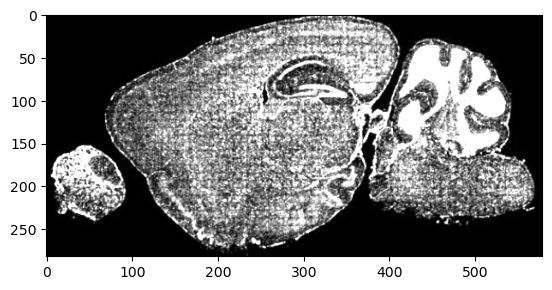

In [8]:
#%matplotlib inline
num = 10
plt.imshow(adjustBC(image_from_df(df,num),0,0.9), cmap = 'gray')

### Colormaps

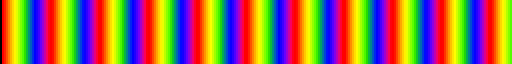

In [8]:
# rainbow colormap
# take the prism colormap and make the zero value black
# turn it into a listed colormap
cmap = cm.prism(np.arange(256))
cmap[0] = [0,0,0,1]
cmap = ListedColormap(cmap)
# set maximum colors to display
max_colors = 1140

cmap

In [9]:
# make an LUT with unique values
def RGB_lut_255(unique_values):
    cmap = (255 * cm.gist_rainbow(np.arange(256))).astype(np.uint8)
    cmap[0] = [0,0,0,1]
    return cmap[np.linspace(0,255,unique_values).astype(int)][:,0:3]

In [9]:
# Allen colormap

df_lut = pd.read_csv(allen_lut_file, names = ['Annotation','R','G','B'])

# make a blank look up table
# this is actually a numpy list
lut = np.zeros([np.amax(df_lut.Annotation) + 1,3], dtype = np.uint8) # add 1 to max value...
# lut needs to be uint8 for RGB
lut.shape

# set the values from the lut
for i,row in df_lut.iterrows():
    lut[row.Annotation] = [row.R,row.G,row.B]

In [10]:
# new subclass colors
temp_df = pd.read_csv(subclass_color_csv_file)
subclass_color = {}
for i, row in temp_df.iterrows():
    subclass_color[row.subclass] = row.color
    
subclass_color['LQ'] = '#ffffff'

# use old DG Glut color
subclass_color['DG Glut'] = '#2bb179'

# Import allen data

In [11]:
#have all of the allen name to annotations at hand
with open(name_to_annotation_file, 'rb') as handle:
    allen_name_to_annots = pickle.load(handle)

len(allen_name_to_annots)

1327

In [12]:
# import nissl

ccf_pixel_size = 25

midline = 228

# sagittal orientation

nissl, header = nrrd.read(ara_nissl_file, index_order='C')
nissl = nissl[midline:,:,:]

# import annotations
annot, header = nrrd.read(ara_annot_file, index_order='C')
annot = annot[midline:,:,:]

print(annot.shape)

(228, 320, 528)


In [14]:
# having some trouble interpolating the annotated image with high values
# hopefully this can shift the values to unused lower values and then shift back the original values
annot_unique = np.unique(annot)

annot_convert = np.zeros(annot_unique[-1] + 1, dtype=np.uint32)
for i,val in enumerate(annot_unique):
    annot_convert[val] = i

annot_revert = np.zeros(len(annot_unique), dtype=np.uint32)
for i,val in enumerate(annot_unique):
    annot_revert[i] = val

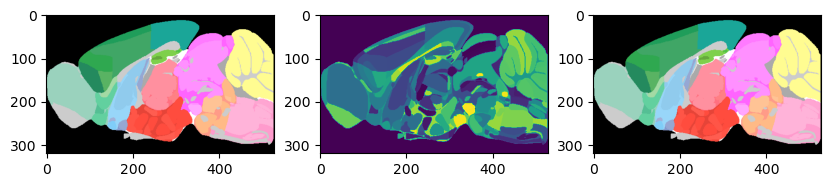

In [15]:
# here is an example
slice_num = 10
fig, axs = plt.subplots(1,3, figsize = (10,5))
axs[0].imshow(lut[annot[slice_num]])
axs[1].imshow(annot_convert[annot[slice_num]])
axs[2].imshow(lut[annot_revert[annot_convert[annot[slice_num]]]])

In [13]:
# import border image
# see "allen annotation to border.ipynb" notebook for how to generate these
# useful for displaying purposes

borders = skimage.io.imread(allen_border_file)
borders = borders[::-1] # reverse order depending on which hemisphere was used
print(borders.shape)
print(borders.dtype)

(228, 320, 528)
uint8


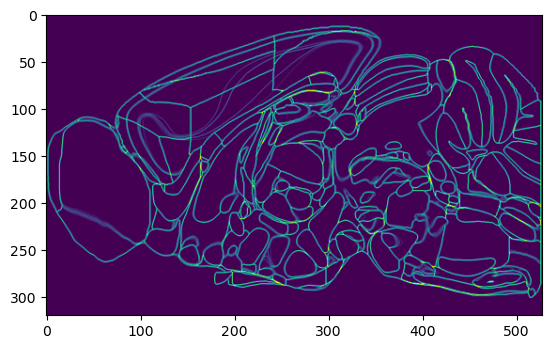

In [17]:
plt.imshow(borders[slice_num])

# interpolate allen slices from cut positions

[  0.81925775 208.26640257]


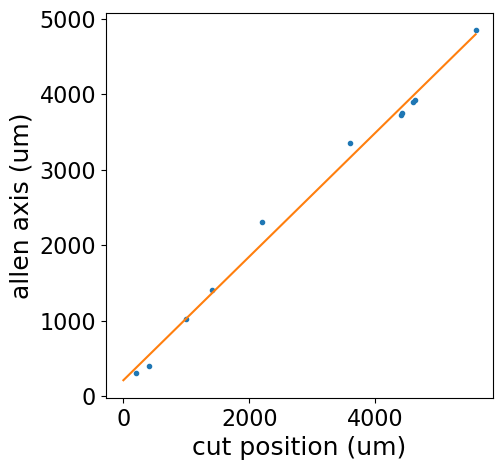

In [18]:
df = pd.read_excel(slice_info_filename)

# sometimes there will be nan values here if we don't fill in this column completely
# can interpolate the values
df.allen_slice_num.values


#####

x = df.z_pos.values[np.logical_not(np.isnan(df.allen_slice_num.values))]

x_slice = df.Slice.values[np.logical_not(np.isnan(df.allen_slice_num.values))]
y = df.allen_slice_num.values[np.logical_not(np.isnan(df.allen_slice_num.values))]

####

um_per_slice_allen = 25

fit = np.polyfit(x, um_per_slice_allen * y, 1)
x_fit = np.arange(np.amax(x))
y_fit = x_fit * fit[0] + fit[1]

print(fit)

fig, axs = plt.subplots(1,1, figsize = (5,5))
fs = 18
axs.plot(x, y * um_per_slice_allen, '.')
axs.plot(x_fit,y_fit)
axs.set_ylabel('allen axis (um)', fontsize=fs)
axs.set_xlabel('cut position (um)', fontsize=fs)
axs.tick_params(axis='both', which='major', labelsize=16)

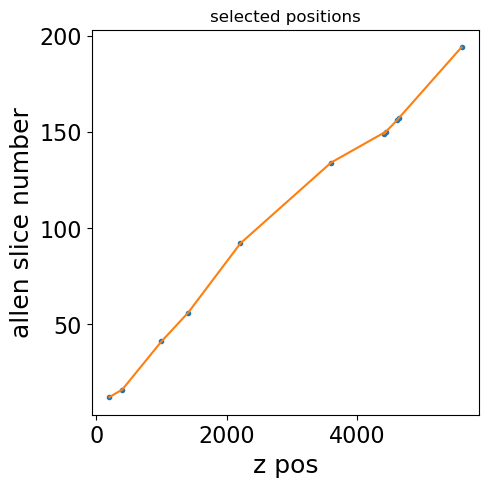

In [19]:
f = scipy.interpolate.interp1d(x, y, kind='linear', fill_value = 'extrapolate')

allen_slice_orig = np.copy(y)
# rewrite the allen slice number with the interpolated version
df.allen_slice_num = f(df.z_pos).astype(int)

fig, axs = plt.subplots(1,1,figsize=(5,5))

axs.set_title('selected positions')
axs.plot(x,allen_slice_orig,'.')
axs.plot(x, f(x))
axs.set_ylabel('allen slice number',fontsize=fs)
axs.set_xlabel('z pos',fontsize=fs)
axs.tick_params(axis='both', which='major', labelsize=16)

In [20]:
# test df importing
df = import_df(slice_info_filename)

# cell metadatas

In [18]:
cmd = pd.read_csv(cmd_file, index_col = 0)
print(len(cmd))
# only take sa samples

cmd = cmd[(cmd.sample_id.str.contains('sa1_') | cmd.sample_id.str.contains('sa2_'))]
cmd.sample_id.unique()

cmd.index.rename('cell_id', inplace = True)
len(cmd)

10025673


2606288

In [22]:
cmd.columns

Index(['fov', 'volume', 'center_x', 'center_y', 'sample_id', 'slice_id',
       'fov_x', 'fov_y', 'integration_partition_transfer',
       'integration_partition_confidence', 'subclass_label_transfer',
       'subclass_label_confidence', 'cl_transfer', 'cl_confidence',
       'cluster_cosine_similarity', 'adjusted_subclass_label_confidence',
       'adjusted_cl_confidence', 'spatial_modules_level_1', 'sm1_color',
       'local_color', 'spatial_modules_level_1_name', 'sm1n_color'],
      dtype='object')

In [23]:
cmd['lvl2_colors'] = cmd.subclass_label_transfer.map(subclass_color)
# handle no subclass
cmd.loc[cmd.subclass_label_transfer.isna(), 'lvl2_colors'] = subclass_color['LQ']                                            

In [24]:
for sm in cmd.spatial_modules_level_1_name.unique():
    print(sm)

nan
SM_CTX
SM_FT
SM_OLF/HPF
SM_CB
SM_CB/FT
SM_STR
SM_VS
SM_PAL/STR
SM_HB
SM_MB
SM_TH
SM_HY
SM_RT
SM_MOB outer
SM_MOB inner
SM_RSP


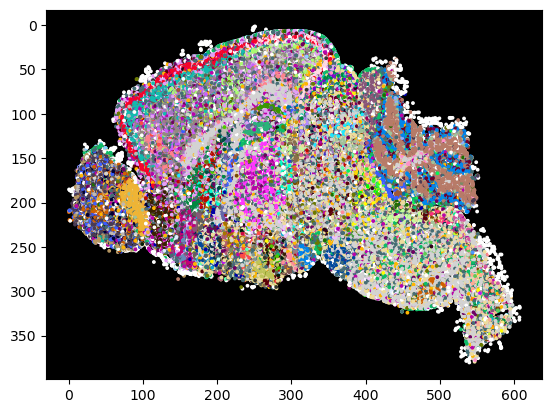

In [25]:
num = 1
cells = get_cell_metadata_for_slice_index(df, num, cmd, ccf_pixel_size = 25)

plt.figure()
#fixed = imagescPercent(image_from_df(df, num), 0, rescale_percent)
#plt.imshow(fixed, cmap = 'gray')
plt.gca().set_facecolor((0,0,0))
plt.scatter(cells['fixed_x'], cells['fixed_y'], s = 3, c = cells.lvl2_colors)
plt.gca().invert_yaxis()

In [26]:
# make a place to store the raw cell metatdata
cmd_orig = cmd.copy()

# modify nissl

In [ ]:
# due to difficulty in registering the olfactory bulb
# split the registration into two parts
# the OB will be segmented out in the fixed and moving images
# and registered separately

In [27]:
annots_to_amplify = [507, 698, 665, 538, 900] + [632]
annots_to_amplify = annots_to_amplify + allen_name_to_annots['Isocortex']

# these will help us remove the olfactory bulb
annots_to_remove = [1016, 698, 507] + [196,204,188,538]
annots_to_remove

[1016, 698, 507, 196, 204, 188, 538]

In [28]:
# enhance certain regions of nissl image
# this code has been modified to help remove areas

def modify_nissl(nissl, annot, factor = 5, annot_dict = None, midline = 228, remove_list = None, expand = 1, right_crop = 120):
    output = np.copy(nissl)
    mask = annot > 0
    output = output * mask # clear outside the annotation
    
    mean_val = np.mean(output[output > 0])
    output_inverse = np.copy(output)

    annot = np.rint(annot).astype(np.int32)
    
    # first remove annotations in the list 
    # only remove the largest annotated region... (ex olf bulb...)
    if not remove_list is None:
        mask = np.isin(annot, remove_list)
        mask[:,right_crop:] = False # specific to OB
                
        labels = skimage.measure.label(mask)
        rprops = skimage.measure.regionprops(labels)
        if len(rprops) > 0:
            areas = [p.area for p in rprops]
            argmax = np.argmax(areas)
            mask = (labels == rprops[argmax].label)
        
        output_inverse *= mask
        output_inverse_mean = np.mean(output_inverse[output_inverse > 0])
        mask = np.logical_not(mask)
        output = mask * output
    
    # vlmc layer
    mask = output > 0
    surface = np.logical_xor(mask, skimage.morphology.binary_dilation(mask, skimage.morphology.disk(2)))
    output[surface] = mean_val * factor # add vlmc
    
    mask = output_inverse > 0
    surface = np.logical_xor(mask, skimage.morphology.binary_dilation(mask, skimage.morphology.disk(2)))
    output_inverse[surface] = mean_val * factor # add vlmc

    # Ependymal NN
    annots_ENN = [81,129]
    ventrical_mask = np.isin(annot, annots_ENN)
    edge_mask = np.logical_xor(ventrical_mask, skimage.morphology.binary_erosion(ventrical_mask, skimage.morphology.disk(1)))
    
    output = output * np.logical_not(ventrical_mask).astype(int) # remove ventricals
    output += edge_mask * mean_val * factor # add surface

    if not annot_dict is None:
        for val in annot_dict:
            mask_1 = np.logical_and(annot == val, output > 0)
            mask_2 = np.logical_and(annot == val, output_inverse > 0)
            output += mask_1 * mean_val * factor
            output_inverse += mask_2 * mean_val * factor

    return output, output_inverse

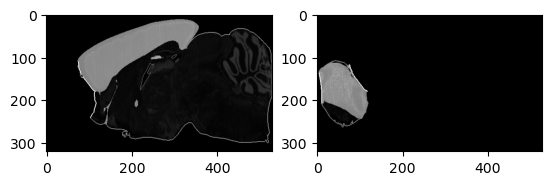

In [29]:
allen_slice_num = 10

output, output_inverse = modify_nissl(
                nissl[allen_slice_num],
                annot[allen_slice_num],
                annot_dict = annots_to_amplify,
                remove_list = annots_to_remove,
                factor = 10)

fig, axs = plt.subplots(1,2)
axs[0].imshow(output, cmap = 'gray')
axs[1].imshow(output_inverse, cmap = 'gray')

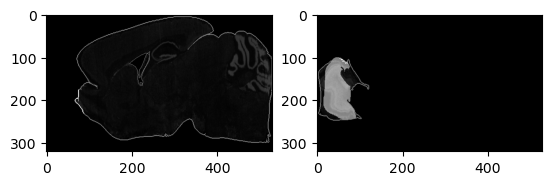

In [30]:
slice_num = 5
num = slice_num - 1

output, output_inverse = modify_nissl(
                nissl[df.iloc[num].allen_slice_num],
                annot[df.iloc[num].allen_slice_num],
                #annot_dict = df.iloc[num].annots_to_amplify,
                annot_dict = [507],
                remove_list = df.iloc[num].annots_to_remove,
                factor = 10)

fig, axs = plt.subplots(1,2)
axs[0].imshow(output, cmap = 'gray')
axs[1].imshow(output_inverse, cmap = 'gray')

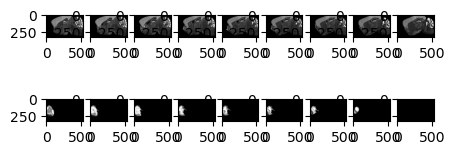

In [31]:
slice_num_i = 1
slice_num_f = 10

fig, axs = plt.subplots(2, slice_num_f-slice_num_i, figsize = [5,2])
for i,num in enumerate(np.arange(slice_num_i, slice_num_f)):
    
    allen_slice_num = df.iloc[num].allen_slice_num
    output, output_inverse =  modify_nissl(
                    nissl[allen_slice_num],
                    annot[allen_slice_num],
                    annot_dict = annots_to_amplify,
                    remove_list = annots_to_remove,
                    factor = 1)
    
    axs[0,i].imshow(adjustBC(output,0,0.99), cmap = 'gray')
    axs[1,i].imshow(adjustBC(output_inverse,0,0.99), cmap = 'gray')

# modify dapi

In [32]:
cell_types_to_amplify = ['VLMC NN', 'Ependymal NN', 'CHOR NN', 'Tanyctye NN']
cell_types_to_amplify = cell_types_to_amplify + ['ABC NN', 'Astroependymal NN'] + ['DG Glut']

mob_cells = [
'MOB Dopa-Gaba',
'MOB Eomes Ms4a15 Glut',
'MOB Meis2 Gaba',
'MOB Trdn Gaba',
'MOB-STR-CTX Inh IMN',
'MOB-in Frmd7 Gaba',
'MOB-mi Frmd7 Gaba',
'MOB-out Frmd7 Gaba',
'IT AON-TT-DP Glut']

cell_types_to_amplify = cell_types_to_amplify + mob_cells

In [33]:
# enhance certain regions of the dapi image using cell type information
# this code has been modified to help remove areas

def modify_dapi(df, num, cmd, cell_types = None, space_modules = None, ccf_pixel_size = 25, factor = 10, cell_types_to_remove = None):
    dapi = image_from_df(df, num)
    cells = get_cell_metadata_for_slice_index(df, num, cmd, ccf_pixel_size = ccf_pixel_size)
    
    mean_val = np.mean(dapi[dapi > 0])
    
    ymax,xmax = dapi.shape
    mask = np.zeros(dapi.shape)
    
    cells = get_cell_metadata_for_slice_index(df, num, cmd, ccf_pixel_size = ccf_pixel_size)
    x = np.round(cells.fixed_x).astype(int)
    y = np.round(cells.fixed_y).astype(int)
    
    cond = ((x > 0) & (x < (xmax -1)) &
            (y > 0) & (y < (ymax -1)))
    cells = cells[cond]
    
    # enhance cell types
    if not cell_types is None:
        mask2 = np.zeros(dapi.shape)
        df_temp = cells[cells.subclass_label_transfer.isin(cell_types)]
        x = np.round(df_temp.fixed_x).astype(int)
        y = np.round(df_temp.fixed_y).astype(int)
        mask2[y,x] = mean_val * factor
        mask2 = skimage.filters.gaussian(mask2, sigma = 1)
        dapi += mask2
        
    # enhance space modules
    if not space_modules is None:
        mask2 = np.zeros(dapi.shape)
        df_temp = cells[cells.spatial_modules_level_1_name.isin(space_modules)]
        x = np.round(df_temp.fixed_x).astype(int)
        y = np.round(df_temp.fixed_y).astype(int)
        mask2[y,x] = mean_val * factor
        mask2 = skimage.filters.gaussian(mask2, sigma = 1)
        dapi += mask2
    
    #mask = skimage.morphology.binary_dilation(mask, skimage.morphology.disk(1))
    #dapi += mask * mean_val * factor 
    
    # remove any modifications after 'right crop'
    # important for sagittal
    if not np.isnan(df.iloc[num]['right_crop']):
        rc = df.iloc[num]['right_crop']
        sx = df.iloc[num]['scale_x']
        rc_new = int(np.round(rc * sx))
        dapi[:,rc_new:] = 0
        
    # mask out cell types
    dapi_inverse = np.copy(dapi)

    mask1 = np.zeros(dapi.shape)
    if not cell_types_to_remove is None:
        df_temp = cells[cells.subclass_label_transfer.isin(cell_types_to_remove)]
        x = np.round(df_temp.fixed_x).astype(int)
        y = np.round(df_temp.fixed_y).astype(int)
        mask1[y,x] = 1
        mask1 = skimage.morphology.binary_closing(mask1, skimage.morphology.disk(df.iloc[num]['mask_closing']))
        mask1 = skimage.morphology.remove_small_objects(mask1, min_size = df.iloc[num]['mask_min_size'])
        mask1 = skimage.morphology.binary_dilation(mask1, skimage.morphology.disk(df.iloc[num]['mask_dilation']))
        
        mask1[:, :int(df.iloc[num]['mask_left'])] = True
        
        dapi_inverse*= mask1 # this is the inverse mask

        mask2 = np.logical_not(mask1) # this is the dapi mask
        dapi*= mask2
    
    return dapi, dapi_inverse, mask2, mask1 

82
220506_sa_10_merfish4_adaptor_5z18r_slice0_y_-002602_004221_x_-007679_006743_25um_pix.tif
4
100
5
94


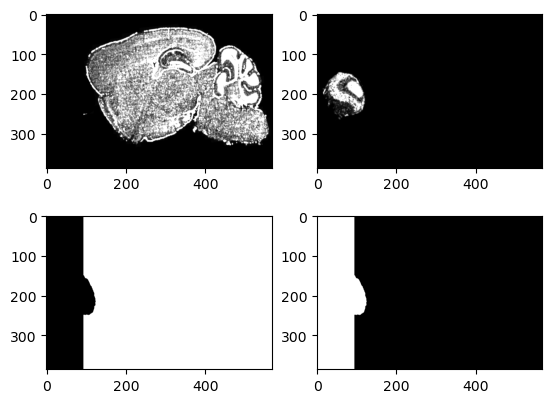

In [34]:
#df = import_df(slice_info_filename)

slice_num = 10
num = slice_num - 1

df = import_df(slice_info_filename)
print(df.iloc[num].allen_slice_num)
print(df.iloc[num].Filename)

print(df.iloc[num].mask_closing)
print(df.iloc[num].mask_min_size)
print(df.iloc[num].mask_dilation)
print(df.iloc[num].mask_left)

dapi_mod, dapi_mod_inv, mask2, mask1 = modify_dapi(df, num, cmd,
                             cell_types = df.iloc[num].cell_types,
                             cell_types_to_remove = df.iloc[num].cell_types_to_remove,
                             factor = 10)
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(adjustBC(dapi_mod,0,0.9), cmap = 'gray')
axs[0,1].imshow(adjustBC(dapi_mod_inv,0,0.99), cmap = 'gray')
axs[1,0].imshow(mask2, cmap = 'gray')
axs[1,1].imshow(mask1, cmap = 'gray')

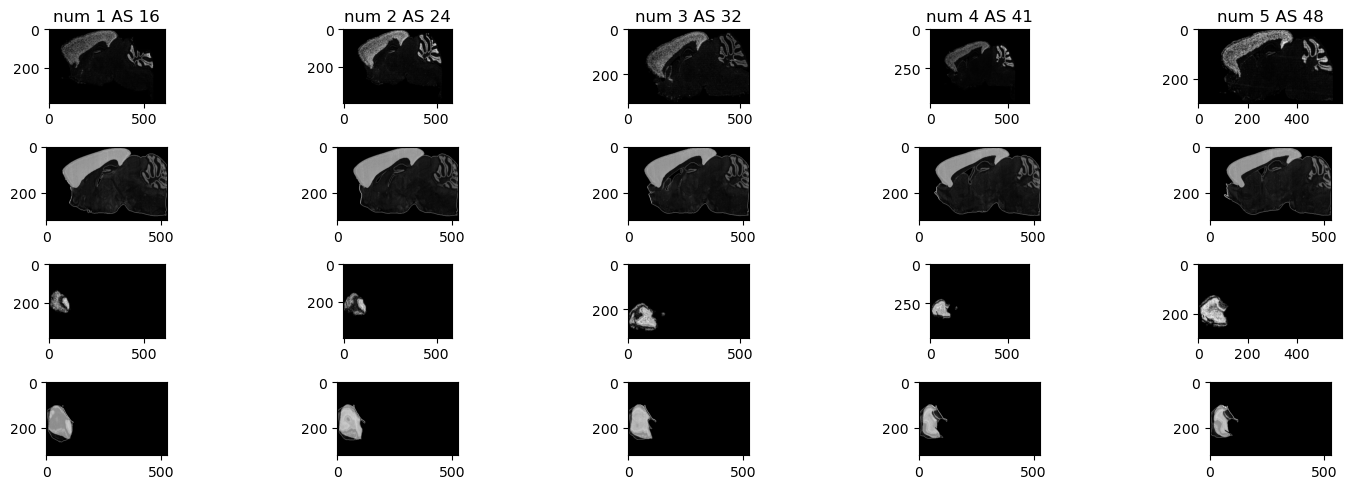

In [35]:
# make some side by side plots

num_start = 1
df = import_df(slice_info_filename)

ncols = 5
fig, axs = plt.subplots(4, ncols, figsize = (15,5))

for i in range(ncols):
    num = num_start + i
    nissl_im = nissl[df.iloc[num].allen_slice_num]
    annot_im = annot[df.iloc[num].allen_slice_num]
    
    nissl_1, nissl_2 = modify_nissl(nissl_im, annot_im,
                                    annot_dict = df.iloc[num].annots_to_amplify,
                                    remove_list = df.iloc[num].annots_to_remove)
    dapi_1, dapi_2, _, _ = modify_dapi(df, num, cmd,
                                       cell_types = df.iloc[num].cell_types_to_remove,
                                       space_modules = df.iloc[num].space_modules,
                                       cell_types_to_remove = df.iloc[num].cell_types_to_remove)
    
    axs[0,i].set_title('num {} AS {}'.format(num, df.iloc[num].allen_slice_num))
    axs[0,i].imshow(dapi_1, cmap = 'gray')
    axs[1,i].imshow(nissl_1, cmap = 'gray')
    axs[2,i].imshow(dapi_2, cmap = 'gray')
    axs[3,i].imshow(nissl_2, cmap = 'gray')
plt.tight_layout()

In [ ]:
# make two separate annotation files
# one for only the OB
# one for the everything except the OB
# these two areas will be registered separately and stitched together later

In [36]:
def remove_annotation(annot, remove_list, right_crop = 120, min_size = 200):
    output = np.copy(annot)
    output = np.rint(output).astype(np.int32)

    mask = np.isin(output, remove_list)
    mask[:,:,right_crop:] = False # specific to OB
    
    for i, frame in enumerate(mask):

        labels = skimage.measure.label(frame)
        rprops = skimage.measure.regionprops(labels)
        
        if len(rprops) > 0:
            areas = [p.area for p in rprops]
            argmax = np.argmax(areas)
            if rprops[argmax].area > min_size: # only if the region meets a size criteria
                mask[i] = (labels == rprops[argmax].label)
            else:
                mask[i] = 0
        
    mask = np.logical_not(mask)
    output = np.rint(output * mask).astype(np.int32)
    return output

In [37]:
# these are the same for all slices
annots_to_remove = [1016, 698, 507, 196,204,188,538]

# use this to regsister the no olf area
annot_no_olf = remove_annotation(annot, annots_to_remove)

mask = np.logical_not(annot_no_olf > 0)

annot_olf_only = np.rint(annot * mask).astype(np.int32)

In [38]:
#skimage.io.imsave('annot_no_olf.tif', annot_no_olf)
#skimage.io.imsave('annot_olf_only.tif', annot_olf_only)

In [39]:
# make a copy of the annotation
annot_orig = np.copy(annot)

# 2D Registration

In [40]:
# use the original cell metadata
cmd = cmd_orig.copy()

In [ ]:
# note that for the sagittal registration 
# the ccfx and ccfz names are flipped in this notebook
# This was to use the same code as the coronal notebooks
# ccfx and ccfz will renamed correctly at the end

###      Registration with no OB

In [41]:
%matplotlib qt

In [42]:
# test the registration of a slice
# parameters for registration are stored in the slice_info_filename
# an interactive popup window will appear
# alternately click on left image then right image to record corresponding points
# run the following cell to save a csv file
# the code will automatically find a csv file if it is present

In [43]:
slice_to_register = 1

print('start register slice {}'.format(slice_to_register))

num = slice_to_register - 1

df = import_df(slice_info_filename)
ccf_pixel_size = 25

filename = df.iloc[num].Filename
allen_slice_num = df.iloc[num].allen_slice_num
print(filename)
print(allen_slice_num)

rescale_percent = 0.99
pad_width = 20

moving_annot = annot[allen_slice_num]
moving_borders = borders[allen_slice_num]
nissl_im = nissl[allen_slice_num]

print('nissl factor {}'.format(df.iloc[num].nissl_enhance_factor))
print('dapi factor {}'.format(df.iloc[num].dapi_enhance_factor))

fixed, _, mask, _ = modify_dapi(df, num, cmd,
    cell_types = df.iloc[num].cell_types,
    space_modules = df.iloc[num].space_modules,
    cell_types_to_remove = df.iloc[num].cell_types_to_remove,
    factor = df.iloc[num].dapi_enhance_factor)

moving, _  = modify_nissl(nissl_im, moving_annot,
    annot_dict = df.iloc[num].annots_to_amplify,
    remove_list = df.iloc[num].annots_to_remove,
    factor = df.iloc[num].nissl_enhance_factor)

# crop images (may not be necessary since we did it already) and add a pad
_, _, fixed_mask = crop_and_pad_image(fixed, mask, pad_width = pad_width, area_thresh = 300)
fix_bbox, fixed, _ = crop_and_pad_image(fixed, pad_width = pad_width, area_thresh = 300)
_, _, moving_borders = crop_and_pad_image(moving, moving_borders, pad_width = pad_width, area_thresh = 300) # be careful here don't overwrite the original moving...
mov_bbox, moving, moving_annot = crop_and_pad_image(moving, moving_annot, pad_width = pad_width, area_thresh = 300) 

cells = get_cell_metadata_for_slice_index(df, num, cmd, ccf_pixel_size = ccf_pixel_size, bbox = fix_bbox, pad_width = pad_width)

### only choose select cells that fall in this mask
fixed_mask = fixed_mask.astype(bool)
cells_valid = ((cells['fixed_x'] > 0) & 
               (cells['fixed_x'] < fixed_mask.shape[1]) &
               (cells['fixed_y'] > 0) & 
               (cells['fixed_y'] < fixed_mask.shape[0]))
cells = cells[cells_valid]

cells_in_mask = fixed_mask[
    cells['fixed_y'].values.astype(int),
    cells['fixed_x'].values.astype(int)]
cells = cells[cells_in_mask]

fig, axs = plt.subplots(2,1, figsize = [15,20])
axs[0].imshow(fixed, cmap = 'gray', picker=True, vmin = 0, vmax = 0.5 * np.amax(fixed))
#axs[0].set_facecolor((0,0,0))
axs[0].scatter(cells['fixed_x'], cells['fixed_y'], s = 0.2, c = cells.lvl2_colors)

axs[1].imshow(lut[moving_annot],  picker=True)
axs[1].imshow(moving, cmap = 'gray', alpha = 0.5)
axs[1].imshow(moving_borders, alpha = 0.5, cmap = 'gray')

plt.tight_layout()

fig.suptitle(filename)

# reset or add more points?
if True:
    points_cor_x = []
    points_cor_y = []
    
fig.canvas.mpl_connect('pick_event', onpick)

start register slice 1
220609_wb3_sa1_1_5z18R_merfish5_slice0_y_-002984_003238_x_-005648_007574_25um_pix.tif
12
nissl factor 5
dapi factor 5


14

In [755]:
# if this cell is run, the points will be saved (or overwritten)

filename_csv = os.path.splitext(filename)[0] + 'no_olf.csv'

df_points = pd.DataFrame()
df_points['fix_x'] = np.array(points_cor_x)[::2]
df_points['fix_y'] = np.array(points_cor_y)[::2]
df_points['mov_x'] = np.array(points_cor_x)[1::2]
df_points['mov_y'] = np.array(points_cor_y)[1::2]

df_points.to_csv(filename_csv, index=False)

print(filename_csv)
df_points

220620_sa_14_19B_merfish4_adaptor_slice0_y_-004980_004242_x_-006617_-00993_25um_pixno_olf.csv


,fix_x,fix_y,mov_x,mov_y
0,95.231040,166.086047,113.508845,148.860217
1,153.288467,185.863851,147.322511,171.827990
2,187.740126,167.362034,182.412164,159.706110
3,179.446208,120.788495,178.584202,113.132570
4,204.965956,192.881782,197.724013,186.501845
5,307.044947,134.186362,301.078991,130.996394
6,340.220619,71.024986,342.548581,84.422854
7,311.510903,157.154135,301.078991,166.086047
8,346.600556,190.329807,328.512720,201.813694
9,335.754663,169.276015,320.218802,181.397896


In [44]:
# careful here using an annotation that does not contain the OB

csv_file = os.path.splitext(filename)[0] + 'no_olf.csv'

fix_points = None
if os.path.exists(csv_file):
    print(csv_file)
    p, p2 = params_from_df(df, num, cor_pts = True)
    
    print('corresponding points found')
    cor_points = pd.read_csv(csv_file)
    fix_points = cor_points[['fix_x', 'fix_y']].values
    mov_points = cor_points[['mov_x', 'mov_y']].values
    
    write_pts_file(fix_points, name = 'fix.pts')
    write_pts_file(mov_points, name = 'mov.pts')
    
else:
    p, p2 = params_from_df(df, num)

print('slice num {}'.format(df.iloc[num].Slice))
print('allen slice {}'.format(allen_slice_num))
print('registering in progress')

# register a slice to allen
trans, moving_spline = register_images(fixed, moving, p, p2)

# transform other images
moving_rigid = transform_image(moving, trans[0])
moving_annot_rigid = annot_revert[transform_image(annot_convert[moving_annot], trans[0], interpolation = False).astype(np.uint32)]
moving_annot_spline = annot_revert[transform_image(annot_convert[moving_annot], trans, interpolation = False).astype(np.uint32)]
moving_borders_spline = transform_image(moving_borders, trans, interpolation = True)

# get some cell positions
if True:

    cells_pos_fixed = np.array([cells['fixed_x'], cells['fixed_y']]).T #- 0.5 correction to ITK?
    write_pts_file(cells_pos_fixed) # write the files to the disk

    # warp the points
    transformixImageFilter = sitk.TransformixImageFilter()
    transformixImageFilter.SetTransformParameterMap(trans)
    transformixImageFilter.SetMovingImage(sitk.GetImageFromArray(moving))
    transformixImageFilter.SetFixedPointSetFileName('points.pts')
    transformixImageFilter.Execute()

    output_points = read_outputpoints_file()
    
    cells_pos_moving = output_points[:,3]
    
    cells_pos_moving -= pad_width # remove the pad
    cells_pos_moving += np.array([mov_bbox[1], mov_bbox[0]]) # adjust for moving crop

    zloc = np.ones(len(cells_pos_moving)) * allen_slice_num
    yloc = cells_pos_moving[:,1]
    xloc = cells_pos_moving[:,0]
    
    zloc_int = zloc.astype(int)
    yloc_int = yloc.astype(int)
    xloc_int = xloc.astype(int)
    
    z_valid = ((zloc_int > 0) & (zloc_int < annot.shape[0]))
    y_valid = ((yloc_int > 0) & (yloc_int < annot.shape[1]))
    x_valid = ((xloc_int > 0) & (xloc_int < annot.shape[2]))
    valid = z_valid & y_valid & x_valid

    # careful here we are using an alternative set of annotations
    cells_annotations = annot_no_olf[zloc_int[valid], yloc_int[valid], xloc_int[valid]]

    ccfx = ccf_pixel_size * zloc[valid] # AP axis
    ccfy = ccf_pixel_size * yloc[valid] #
    ccfz = ccf_pixel_size * xloc[valid] #
    
    index_valid = cells.index[valid]
    cmd.loc[index_valid,'ccfx'] = ccfx
    cmd.loc[index_valid,'ccfy'] = ccfy
    cmd.loc[index_valid,'ccfz'] = ccfz
    cmd.loc[index_valid,'annotation'] = cells_annotations # only assign value annotations
    
### This is plotting to compare cells positions to borders ###

color_map = 'lvl2_colors'

percent_high = 0.95

fig, axs = plt.subplots(nrows = 3, ncols = 4, figsize = (10,7))
fig.suptitle('slice {} to allen {}'.format(df.iloc[num].Slice, allen_slice_num), fontsize=16)

axs[0,0].set_title('fixed slice {}'.format(df.iloc[num].Slice))
axs[0,0].imshow(imagescPercent(fixed,0, percent_high), cmap = 'gray')
#axs[0,0].scatter(cells['fixed_x'], cells['fixed_y'])

axs[0,1].set_title('fixed + rigid')
axs[0,1].imshow(
    imageoverlay(
    imagescPercent(scale_result(fixed),0.0, percent_high),
    imagescPercent(scale_result(moving_rigid),0.0,percent_high)
            ))

axs[0,2].set_title('fixed + spline')
axs[0,2].imshow(
    imageoverlay(
    imagescPercent(scale_result(fixed),0.0, percent_high),
    imagescPercent(scale_result(moving_spline),0.0,percent_high)
            ))

axs[0,3].set_title('fixed + borders spline')
axs[0,3].imshow(imagescPercent(fixed,0, percent_high), cmap = 'gray')
axs[0,3].imshow(border_transparency(moving_borders_spline, RGBval = [1,0,1]))

axs[1,0].set_title('moving allen {}'.format(allen_slice_num))
axs[1,0].imshow(imagescPercent(moving,0, percent_high), cmap = 'gray')

axs[1,1].set_title('moving rigid')
axs[1,1].imshow(imagescPercent(moving_rigid,0, percent_high), cmap = 'gray')

axs[1,2].set_title('moving spline')
axs[1,2].imshow(imagescPercent(moving_spline,0, percent_high), cmap = 'gray')

axs[2,0].set_title('borders')
axs[2,0].set_facecolor((0,0,0))
axs[2,0].imshow(border_transparency(moving_borders, RGBval = [1,0,1]))

axs[2,1].set_title('moving + borders')
axs[2,1].imshow(imagescPercent(moving,0, percent_high), cmap = 'gray')
axs[2,1].imshow(border_transparency(moving_borders, RGBval = [1,0,1]))

axs[2,2].set_title('moving + borders spline')
axs[2,2].imshow(imagescPercent(moving_spline,0, percent_high), cmap = 'gray')
axs[2,2].imshow(border_transparency(moving_borders_spline, RGBval = [1,0,1]))

# all cells
fig3, axs = plt.subplots(2,1, figsize = (13,17))

axs[0].imshow(border_transparency(moving_borders_spline, RGBval = [0,0,0]))

axs[1].set_title('slice {}'.format(slice_to_register))
axs[1].set_facecolor((1,1,1))
axs[1].scatter(cells['fixed_x'], cells['fixed_y'], s = 0.1, c = cells[color_map], edgecolor = None)
axs[1].imshow(border_transparency(moving_borders_spline, RGBval = [0,0,0]))
axs[1].plot(*fix_points.T, 'b.', markersize = 15)

plt.tight_layout()
#y,x = np.nonzero(moving_borders_spline > 0)
#axs.plot(x,y, 's')
print('done')

220609_wb3_sa1_1_5z18R_merfish5_slice0_y_-002984_003238_x_-005648_007574_25um_pixno_olf.csv
corresponding points params
corresponding points found
slice num 1.0
allen slice 12
registering in progress
load corresponding points
done


In [45]:
# all cells
fig3, axs = plt.subplots(2,1, figsize = (13,17))

axs[0].imshow(border_transparency(moving_borders_spline, RGBval = [0,0,0]))

axs[1].set_title('slice {}'.format(slice_to_register))
axs[1].set_facecolor((1,1,1))
axs[1].scatter(cells['fixed_x'], cells['fixed_y'], s = 0.1, c = cells[color_map], edgecolor = None)
axs[1].imshow(border_transparency(moving_borders_spline, RGBval = [0,0,0]))
axs[1].plot(*fix_points.T, 'b.', markersize = 15)

### Loop through slices

In [362]:
# start with fresh cell metadata
cmd = cmd_orig.copy()

In [363]:
istart = 1 #
istop = 28 #
rescale_percent = 0.99

In [364]:
matplotlib.use('Agg')

plotQ = True

# Do a loop of a bunch of slices
slices_to_register = np.arange(istart,istop).astype(int)

for slice_to_register in slices_to_register:
    
    print('working on slice {}'.format(slice_to_register))
    
    # Do a big loop to test many registration angles of this slice
    num = slice_to_register - 1

    df = import_df(slice_info_filename)
    
    ccf_pixel_size = 25

    print('{}/{}'.format(slice_to_register,slices_to_register[-1]), end = '\r')

    filename = df.iloc[num].Filename
    allen_slice_num = df.iloc[num].allen_slice_num

    rescale_percent = 0.99

    moving_annot = annot[allen_slice_num]
    moving_borders = borders[allen_slice_num]
    nissl_im = nissl[allen_slice_num]

    fixed, _, mask, _ = modify_dapi(df, num, cmd,
        cell_types = df.iloc[num].cell_types,
        space_modules = df.iloc[num].space_modules,
        cell_types_to_remove = df.iloc[num].cell_types_to_remove,
        factor = df.iloc[num].dapi_enhance_factor)

    moving, _  = modify_nissl(nissl_im, moving_annot,
        annot_dict = df.iloc[num].annots_to_amplify,
        remove_list = df.iloc[num].annots_to_remove,
        factor = df.iloc[num].nissl_enhance_factor)

    csv_file = os.path.splitext(filename)[0] + 'no_olf.csv'
    if os.path.exists(csv_file):

        p, p2 = params_from_df(df, num, cor_pts = True)

        print('corresponding points found')
        cor_points = pd.read_csv(csv_file)
        fix_points = cor_points[['fix_x', 'fix_y']].values
        mov_points = cor_points[['mov_x', 'mov_y']].values

        write_pts_file(fix_points, name = 'fix.pts')
        write_pts_file(mov_points, name = 'mov.pts')

    else:
        p, p2 = params_from_df(df, num)

    pad_width = 20

    # crop images (may not be necessary since we did it already) and add a pad
    _, _, fixed_mask = crop_and_pad_image(fixed, mask, pad_width = pad_width, area_thresh = 300)
    fix_bbox, fixed, _ = crop_and_pad_image(fixed, pad_width = pad_width, area_thresh = 300)
    _, _, moving_borders = crop_and_pad_image(moving, moving_borders, pad_width = pad_width, area_thresh = 300) # be careful here don't overwrite the original moving...
    mov_bbox, moving, moving_annot = crop_and_pad_image(moving, moving_annot, pad_width = pad_width, area_thresh = 300) 

    # register a slice to allen
    trans, moving_spline = register_images(fixed, moving, p, p2)

    # transform other images
    moving_rigid = transform_image(moving, trans[0])
    moving_annot_rigid = annot_revert[transform_image(annot_convert[moving_annot], trans[0], interpolation = False).astype(np.uint32)]
    moving_annot_spline = annot_revert[transform_image(annot_convert[moving_annot], trans, interpolation = False).astype(np.uint32)]
    moving_borders_spline = transform_image(moving_borders, trans, interpolation = True)

    # get some cell positions
    cells = get_cell_metadata_for_slice_index(df, num, cmd, ccf_pixel_size = ccf_pixel_size, bbox = fix_bbox)
    
    ### only choose select cells that fall in this mask
    fixed_mask = fixed_mask.astype(bool)
    cells_valid = ((cells['fixed_x'] > 0) & 
                   (cells['fixed_x'] < fixed_mask.shape[1]) &
                   (cells['fixed_y'] > 0) & 
                   (cells['fixed_y'] < fixed_mask.shape[0]))
    cells = cells[cells_valid]

    cells_in_mask = fixed_mask[
        cells['fixed_y'].values.astype(int),
        cells['fixed_x'].values.astype(int)]
    cells = cells[cells_in_mask]

    # only proceed if we have some cell metadata
    if len(cells) > 0:

        cells_pos_fixed = np.array([cells['fixed_x'], cells['fixed_y']]).T #
        write_pts_file(cells_pos_fixed) # write the files to the disk

        # warp the points
        transformixImageFilter = sitk.TransformixImageFilter()
        transformixImageFilter.SetTransformParameterMap(trans)
        transformixImageFilter.SetMovingImage(sitk.GetImageFromArray(moving))
        transformixImageFilter.SetFixedPointSetFileName('points.pts')
        transformixImageFilter.Execute()

        output_points = read_outputpoints_file()

        cells_pos_moving = output_points[:,3]

        cells_pos_moving -= pad_width # remove the pad
        cells_pos_moving += np.array([mov_bbox[1], mov_bbox[0]]) # adjust for moving crop

        zloc = np.ones(len(cells_pos_moving)) * allen_slice_num
        yloc = cells_pos_moving[:,1]
        xloc = cells_pos_moving[:,0]

        # make integer locations
        zloc_int = zloc.astype(int)
        yloc_int = yloc.astype(int)
        xloc_int = xloc.astype(int)

        # take only valid pixels
        z_valid = ((zloc_int > 0) & (zloc_int < annot.shape[0]))
        y_valid = ((yloc_int > 0) & (yloc_int < annot.shape[1]))
        x_valid = ((xloc_int > 0) & (xloc_int < annot.shape[2]))
        valid = z_valid & y_valid & x_valid

        # careful here we are using an alternative set of annotations

        cells_annotations = annot_no_olf[zloc_int[valid], yloc_int[valid], xloc_int[valid]]

        ccfx = ccf_pixel_size * zloc[valid] # AP axis
        ccfy = ccf_pixel_size * yloc[valid] #
        ccfz = ccf_pixel_size * xloc[valid] #

        index_valid = cells.index[valid] # only use valid index
        cmd.loc[index_valid,'ccfx'] = ccfx
        cmd.loc[index_valid,'ccfy'] = ccfy
        cmd.loc[index_valid,'ccfz'] = ccfz
        cmd.loc[index_valid,'annotation'] = cells_annotations # only assign value annotations
        cmd.loc[index_valid,'note'] = 'no olf'
        
        if plotQ:

            color_map = 'lvl2_colors'

            percent_high = 0.99
            fig, axs = plt.subplots(nrows = 3, ncols = 4, figsize = (10,7))
            fig.suptitle('slice {} to allen {}'.format(df.iloc[num].Slice, allen_slice_num), fontsize=16)

            axs[0,0].set_title('fixed slice {}'.format(df.iloc[num].Slice))
            axs[0,0].imshow(imagescPercent(fixed,0, percent_high), cmap = 'gray')
            #axs[0,0].scatter(cells['fixed_x'], cells['fixed_y'])

            axs[0,1].set_title('fixed + rigid')
            axs[0,1].imshow(
                imageoverlay(
                imagescPercent(scale_result(fixed),0.0, percent_high),
                imagescPercent(scale_result(moving_rigid),0.0,percent_high)
                        ))

            axs[0,2].set_title('fixed + spline')
            axs[0,2].imshow(
                imageoverlay(
                imagescPercent(scale_result(fixed),0.0, percent_high),
                imagescPercent(scale_result(moving_spline),0.0,percent_high)
                        ))

            axs[0,3].set_title('fixed + borders spline')
            axs[0,3].imshow(imagescPercent(fixed,0, percent_high), cmap = 'gray')
            axs[0,3].imshow(border_transparency(moving_borders_spline, RGBval = [1,0,1]))

            axs[1,0].set_title('moving allen {}'.format(allen_slice_num))
            axs[1,0].imshow(imagescPercent(moving,0, percent_high), cmap = 'gray')

            axs[1,1].set_title('moving rigid')
            axs[1,1].imshow(imagescPercent(moving_rigid,0, percent_high), cmap = 'gray')

            axs[1,2].set_title('moving spline')
            axs[1,2].imshow(imagescPercent(moving_spline,0, percent_high), cmap = 'gray')


            axs[2,0].set_title('borders')
            axs[2,0].set_facecolor((0,0,0))
            axs[2,0].imshow(border_transparency(moving_borders, RGBval = [1,0,1]))

            axs[2,1].set_title('moving + borders')
            axs[2,1].imshow(imagescPercent(moving,0, percent_high), cmap = 'gray')
            axs[2,1].imshow(border_transparency(moving_borders, RGBval = [1,0,1]))

            axs[2,2].set_title('moving + borders spline')
            axs[2,2].imshow(imagescPercent(moving_spline,0, percent_high), cmap = 'gray')
            axs[2,2].imshow(border_transparency(moving_borders_spline, RGBval = [1,0,1]))
            
            # all cells
            fig3, axs = plt.subplots(1,2, figsize = (15,10))

            axs[0].imshow(border_transparency(moving_borders_spline, RGBval = [0,0,0]))

            axs[1].set_title('borders')
            axs[1].set_facecolor((1,1,1))
            axs[1].scatter(cells['fixed_x'], cells['fixed_y'], s = 0.1, c = cells[color_map], edgecolor = None)
            axs[1].imshow(border_transparency(moving_borders_spline, RGBval = [0,0,0]))




            fig.savefig('slice_{}_allen_{}_reg_{}.jpg'.format(df.iloc[num].cell_metadata,
                                                                                str(allen_slice_num).zfill(3),
                                                                                num), dpi = 300)

            fig3.savefig('slice_{}_allen_{}_reg_{}_cells_all.jpg'.format(df.iloc[num].cell_metadata,
                                                                                str(allen_slice_num).zfill(3),
                                                                                num), dpi = 600)

            plt.close('all')

print('done')    

working on slice 1
corresponding points params
corresponding points found
load corresponding points
working on slice 2
corresponding points params
corresponding points found
load corresponding points
working on slice 3
corresponding points params
corresponding points found
load corresponding points
working on slice 4
corresponding points params
corresponding points found
load corresponding points
working on slice 5
corresponding points params
corresponding points found
load corresponding points
working on slice 6
corresponding points params
corresponding points found
load corresponding points
working on slice 7
corresponding points params
corresponding points found
load corresponding points
working on slice 8
corresponding points params
corresponding points found
load corresponding points
working on slice 9
corresponding points params
corresponding points found
load corresponding points
working on slice 10
corresponding points params
corresponding points found
load corresponding points

C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


corresponding points params
corresponding points found
load corresponding points
working on slice 13


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


corresponding points params
corresponding points found
load corresponding points
working on slice 14


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


corresponding points params
corresponding points found
load corresponding points
working on slice 15


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


corresponding points params
corresponding points found
load corresponding points
working on slice 16


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


corresponding points params
corresponding points found
load corresponding points
working on slice 17


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


corresponding points params
corresponding points found
load corresponding points
working on slice 18


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


corresponding points params
corresponding points found
load corresponding points
working on slice 19


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


corresponding points params
corresponding points found
load corresponding points
working on slice 20


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


corresponding points params
corresponding points found
load corresponding points
working on slice 21


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


corresponding points params
corresponding points found
load corresponding points
working on slice 22


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


corresponding points params
corresponding points found
load corresponding points
working on slice 23


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


corresponding points params
corresponding points found
load corresponding points
working on slice 24


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


working on slice 25


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


working on slice 26


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


working on slice 27


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


done


In [365]:
# save this metadata that does not contain the OB
cmd_wo_OB = cmd.copy()
cmd_wo_OB.to_csv('cmd_wo_OB.csv', index = True, index_label = 'cell_id')

In [366]:
test.slice_id.unique()

array(['sa1_slice23', 'sa1_slice24', 'sa1_slice25', 'sa1_slice16',
       'sa1_slice17', 'sa1_slice10', 'sa1_slice8', 'sa1_slice3',
       'sa1_slice4', 'sa1_slice1', 'sa1_slice15', 'sa1_slice18',
       'sa1_slice2', 'sa1_slice22', 'sa1_slice11', 'sa1_slice14',
       'sa1_slice19', 'sa1_slice5', 'sa1_slice6', 'sa1_slice12',
       'sa1_slice21', 'sa1_slice7', 'sa1_slice13', 'sa1_slice20',
       'sa1_slice9', 'sa2_slice2', 'sa2_slice3', 'sa2_slice1'],
      dtype=object)

### Registration of OB only

In [46]:
# reload the original cell metadata 
cmd = cmd_orig.copy()
print(len(cmd))

2606288


In [47]:
%matplotlib qt

In [48]:
# the pop out can be used to define corresponding points between images
# alternate click on left image then right image to record points

In [49]:
#careful here using a modified annotation with only the OB

slice_to_register = 1

print('start register slice {}'.format(slice_to_register))

num = slice_to_register - 1

df = import_df(slice_info_filename)
ccf_pixel_size = 25

filename = df.iloc[num].Filename
allen_slice_num = df.iloc[num].allen_slice_num

pad_width = 20
rescale_percent = 0.99

moving_annot = annot[allen_slice_num]
moving_borders = borders[allen_slice_num]
nissl_im = nissl[allen_slice_num]

print('nissl factor {}'.format(df.iloc[num].nissl_enhance_factor))
print('dapi factor {}'.format(df.iloc[num].dapi_enhance_factor))

_, fixed, _, mask = modify_dapi(df, num, cmd,
    cell_types = df.iloc[num].cell_types,
    space_modules = df.iloc[num].space_modules,
    cell_types_to_remove = df.iloc[num].cell_types_to_remove,
    factor = df.iloc[num].dapi_enhance_factor)

_, moving  = modify_nissl(nissl_im, moving_annot,
    annot_dict = df.iloc[num].annots_to_amplify_alt,
    remove_list = df.iloc[num].annots_to_remove,
    factor = df.iloc[num].nissl_enhance_factor)

# crop images (may not be necessary since we did it already) and add a pad
_, _, fixed_mask = crop_and_pad_image(fixed, mask, pad_width = pad_width, area_thresh = 400)
fix_bbox, fixed, _ = crop_and_pad_image(fixed, pad_width = pad_width, area_thresh = 400)
_, _, moving_borders = crop_and_pad_image(moving, moving_borders, pad_width = pad_width, area_thresh = 300) # be careful here don't overwrite the original moving...
mov_bbox, moving, moving_annot = crop_and_pad_image(moving, moving_annot, pad_width = pad_width, area_thresh = 300)

cells = get_cell_metadata_for_slice_index(df, num, cmd, ccf_pixel_size = ccf_pixel_size, bbox = fix_bbox, pad_width = pad_width)

### only choose select cells that fall in this mask
fixed_mask = fixed_mask.astype(bool)
cells_valid = ((cells['fixed_x'] > 0) & 
               (cells['fixed_x'] < fixed_mask.shape[1]) &
               (cells['fixed_y'] > 0) & 
               (cells['fixed_y'] < fixed_mask.shape[0]))
cells = cells[cells_valid]

cells_in_mask = fixed_mask[
    cells['fixed_y'].values.astype(int),
    cells['fixed_x'].values.astype(int)]
cells = cells[cells_in_mask]
###

fig, axs = plt.subplots(2,1, figsize = [15,20])
axs[0].imshow(fixed, cmap = 'gray', picker=True)
axs[0].set_facecolor((0,0,0))
axs[0].scatter(cells['fixed_x'], cells['fixed_y'], s = 0.2, c = cells.lvl2_colors)

#axs[1].imshow(lut[moving_annot],  picker=True)
axs[1].imshow(moving,  picker=True, cmap = 'gray')
axs[1].imshow(moving_borders, alpha = 0.5, cmap = 'gray')

plt.tight_layout()

fig.suptitle(filename)

# reset or add more points?
if True:
    points_cor_x = []
    points_cor_y = []

fig.canvas.mpl_connect('pick_event', onpick)

start register slice 1
nissl factor 5
dapi factor 5


C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3977407013.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_1 = np.logical_and(annot == val, output > 0)
C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3977407013.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_2 = np.logical_and(annot == val, output_inverse > 0)


14

In [1002]:
# if this cell is run, the points will be saved (or overwritten)

filename_csv = os.path.splitext(filename)[0] + '_olf.csv'

df_points = pd.DataFrame()
df_points['fix_x'] = np.array(points_cor_x)[::2]
df_points['fix_y'] = np.array(points_cor_y)[::2]
df_points['mov_x'] = np.array(points_cor_x)[1::2]
df_points['mov_y'] = np.array(points_cor_y)[1::2]

df_points.to_csv(filename_csv, index=False)

print(filename_csv)
df_points

220506_sa_10_merfish4_adaptor_5z18r_slice0_y_-002602_004221_x_-007679_006743_25um_pix_olf.csv


,fix_x,fix_y,mov_x,mov_y
0,63.664172,20.797869,37.842007,21.628832
1,21.977543,74.132232,23.148664,36.796154
2,120.676767,74.132232,53.167322,37.112140
3,71.020636,129.918750,36.104085,59.863123


In [50]:
# be careful we will use the modified annotations

csv_file = os.path.splitext(filename)[0] + '_olf.csv'
if os.path.exists(csv_file):
    print(csv_file)
    
    p, p2 = params_from_df(df, num, cor_pts = True)
    
    print('corresponding points found')
    cor_points = pd.read_csv(csv_file)
    fix_points = cor_points[['fix_x', 'fix_y']].values
    mov_points = cor_points[['mov_x', 'mov_y']].values
    
    write_pts_file(fix_points, name = 'fix.pts')
    write_pts_file(mov_points, name = 'mov.pts')
    
else:
    p, p2 = params_from_df(df, num)

pad_width = 20

print('slice num {}'.format(df.iloc[num].Slice))
print('allen slice {}'.format(allen_slice_num))
print('registering in progress')

# register a slice to allen
trans, moving_spline = register_images(fixed, moving, p, p2)

# transform other images
moving_rigid = transform_image(moving, trans[0])
moving_annot_rigid = annot_revert[transform_image(annot_convert[moving_annot], trans[0], interpolation = False).astype(np.uint32)]
moving_annot_spline = annot_revert[transform_image(annot_convert[moving_annot], trans, interpolation = False).astype(np.uint32)]
moving_borders_spline = transform_image(moving_borders, trans, interpolation = True)

# get some cell positions
if True:
    cells = get_cell_metadata_for_slice_index(df, num, cmd, ccf_pixel_size = ccf_pixel_size, bbox = fix_bbox)

    cells_pos_fixed = np.array([cells['fixed_x'], cells['fixed_y']]).T
    write_pts_file(cells_pos_fixed) # write the files to the disk

    # warp the points
    transformixImageFilter = sitk.TransformixImageFilter()
    transformixImageFilter.SetTransformParameterMap(trans)
    transformixImageFilter.SetMovingImage(sitk.GetImageFromArray(moving))
    transformixImageFilter.SetFixedPointSetFileName('points.pts')
    transformixImageFilter.Execute()

    output_points = read_outputpoints_file()
    
    cells_pos_moving = output_points[:,3]
    
    cells_pos_moving -= pad_width # remove the pad
    cells_pos_moving += np.array([mov_bbox[1], mov_bbox[0]]) # adjust for moving crop

    zloc = np.ones(len(cells_pos_moving)) * allen_slice_num
    yloc = cells_pos_moving[:,1]
    xloc = cells_pos_moving[:,0]
    
    zloc_int = zloc.astype(int)
    yloc_int = yloc.astype(int)
    xloc_int = xloc.astype(int)
    
    z_valid = ((zloc_int > 0) & (zloc_int < annot.shape[0]))
    y_valid = ((yloc_int > 0) & (yloc_int < annot.shape[1]))
    x_valid = ((xloc_int > 0) & (xloc_int < annot.shape[2]))
    valid = z_valid & y_valid & x_valid

    #careful here using modified annotation
    cells_annotations = annot_olf_only[zloc_int[valid], yloc_int[valid], xloc_int[valid]]

    ccfx = ccf_pixel_size * zloc[valid] # AP axis
    ccfy = ccf_pixel_size * yloc[valid] #
    ccfz = ccf_pixel_size * xloc[valid] #
    
    index_valid = cells.index[valid]
    cmd.loc[index_valid,'ccfx'] = ccfx
    cmd.loc[index_valid,'ccfy'] = ccfy
    cmd.loc[index_valid,'ccfz'] = ccfz
    cmd.loc[index_valid,'annotation'] = cells_annotations # only assign value annotations
    
    
### This is plotting to compare cells positions to borders ###

color_map = 'lvl2_colors'

percent_high = 0.95

fig, axs = plt.subplots(nrows = 3, ncols = 4, figsize = (10,7))
fig.suptitle('slice {} to allen {}'.format(df.iloc[num].Slice, allen_slice_num), fontsize=16)

axs[0,0].set_title('fixed slice {}'.format(df.iloc[num].Slice))
axs[0,0].imshow(imagescPercent(fixed,0, percent_high), cmap = 'gray')
#axs[0,0].scatter(cells['fixed_x'], cells['fixed_y'])

axs[0,1].set_title('fixed + rigid')
axs[0,1].imshow(
    imageoverlay(
    imagescPercent(scale_result(fixed),0.0, percent_high),
    imagescPercent(scale_result(moving_rigid),0.0,percent_high)
            ))

axs[0,2].set_title('fixed + spline')
axs[0,2].imshow(
    imageoverlay(
    imagescPercent(scale_result(fixed),0.0, percent_high),
    imagescPercent(scale_result(moving_spline),0.0,percent_high)
            ))

axs[0,3].set_title('fixed + borders spline')
axs[0,3].imshow(imagescPercent(fixed,0, percent_high), cmap = 'gray')
axs[0,3].imshow(border_transparency(moving_borders_spline, RGBval = [1,0,1]))

axs[1,0].set_title('moving allen {}'.format(allen_slice_num))
axs[1,0].imshow(imagescPercent(moving,0, percent_high), cmap = 'gray')

axs[1,1].set_title('moving rigid')
axs[1,1].imshow(imagescPercent(moving_rigid,0, percent_high), cmap = 'gray')

axs[1,2].set_title('moving spline')
axs[1,2].imshow(imagescPercent(moving_spline,0, percent_high), cmap = 'gray')

axs[2,0].set_title('borders')
axs[2,0].set_facecolor((0,0,0))
axs[2,0].imshow(border_transparency(moving_borders, RGBval = [1,0,1]))

axs[2,1].set_title('moving + borders')
axs[2,1].imshow(imagescPercent(moving,0, percent_high), cmap = 'gray')
axs[2,1].imshow(border_transparency(moving_borders, RGBval = [1,0,1]))

axs[2,2].set_title('moving + borders spline')
axs[2,2].imshow(imagescPercent(moving_spline,0, percent_high), cmap = 'gray')
axs[2,2].imshow(border_transparency(moving_borders_spline, RGBval = [1,0,1]))

# all cells
fig3, axs = plt.subplots(1,2, figsize = (15,10))

axs[0].imshow(border_transparency(moving_borders_spline, RGBval = [0,0,0]))

axs[1].set_title('slice {}'.format(slice_to_register))
axs[1].set_facecolor((1,1,1))
axs[1].scatter(cells['fixed_x'], cells['fixed_y'], s = 0.1, c = cells[color_map])
axs[1].imshow(border_transparency(moving_borders_spline, RGBval = [0,0,0]))
#y,x = np.nonzero(moving_borders_spline > 0)
#axs.plot(x,y, 's')
print('done')

220609_wb3_sa1_1_5z18R_merfish5_slice0_y_-002984_003238_x_-005648_007574_25um_pix_olf.csv
corresponding points params
corresponding points found
slice num 1.0
allen slice 12
registering in progress
load corresponding points
done


### Loop through slices

In [190]:
# reload the original cell meta data 
cmd = cmd_orig.copy()
print(len(cmd))

2606288


In [191]:
istart = 1 #
istop = 11 # crashes at 11 since OB is gone
rescale_percent = 0.99

np.arange(istart,istop).astype(int)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [192]:
matplotlib.use('Agg')

plotQ = True

# Do a loop of a bunch of slices
slices_to_register = np.arange(istart,istop).astype(int)

for slice_to_register in slices_to_register:
    
    print('working on slice {}'.format(slice_to_register))
    
    # Do a big loop to test many registration angles of this slice
    num = slice_to_register - 1

    df = import_df(slice_info_filename)
    
    ccf_pixel_size = 25

    print('{}/{}'.format(slice_to_register,slices_to_register[-1]), end = '\r')

    filename = df.iloc[num].Filename
    allen_slice_num = df.iloc[num].allen_slice_num

    rescale_percent = 0.99
    pad_width = 20

    moving_annot = annot[allen_slice_num]
    moving_borders = borders[allen_slice_num]
    nissl_im = nissl[allen_slice_num]

    _, fixed, _, mask = modify_dapi(df, num, cmd,
        cell_types = df.iloc[num].cell_types,
        space_modules = df.iloc[num].space_modules,
        cell_types_to_remove = df.iloc[num].cell_types_to_remove,
        factor = df.iloc[num].dapi_enhance_factor)

    _, moving  = modify_nissl(nissl_im, moving_annot,
        annot_dict = df.iloc[num].annots_to_amplify_alt,
        remove_list = df.iloc[num].annots_to_remove,
        factor = df.iloc[num].nissl_enhance_factor)

    # crop images (may not be necessary since we did it already) and add a pad
    _, _, fixed_mask = crop_and_pad_image(fixed, mask, pad_width = pad_width, area_thresh = 400)
    fix_bbox, fixed, _ = crop_and_pad_image(fixed, pad_width = pad_width, area_thresh = 400)
    _, _, moving_borders = crop_and_pad_image(moving, moving_borders, pad_width = pad_width, area_thresh = 300) # be careful here don't overwrite the original moving...
    mov_bbox, moving, moving_annot = crop_and_pad_image(moving, moving_annot, pad_width = pad_width, area_thresh = 300) 

    csv_file = os.path.splitext(filename)[0] + '_olf.csv'
    if os.path.exists(csv_file):
        print(csv_file)

        p, p2 = params_from_df(df, num, cor_pts = True)

        print('corresponding points found')
        cor_points = pd.read_csv(csv_file)
        fix_points = cor_points[['fix_x', 'fix_y']].values
        mov_points = cor_points[['mov_x', 'mov_y']].values

        write_pts_file(fix_points, name = 'fix.pts')
        write_pts_file(mov_points, name = 'mov.pts')

    else:
        p, p2 = params_from_df(df, num)
    
    # register a slice to allen
    trans, moving_spline = register_images(fixed, moving, p, p2)

    # transform other images
    moving_rigid = transform_image(moving, trans[0])
    moving_annot_rigid = annot_revert[transform_image(annot_convert[moving_annot], trans[0], interpolation = False).astype(np.uint32)]
    moving_annot_spline = annot_revert[transform_image(annot_convert[moving_annot], trans, interpolation = False).astype(np.uint32)]
    moving_borders_spline = transform_image(moving_borders, trans, interpolation = True)

    # get some cell positions
    cells = get_cell_metadata_for_slice_index(df, num, cmd, ccf_pixel_size = ccf_pixel_size, bbox = fix_bbox)
    
    ### only choose select cells that fall in this mask
    fixed_mask = fixed_mask.astype(bool)
    cells_valid = ((cells['fixed_x'] > 0) & 
                   (cells['fixed_x'] < fixed_mask.shape[1]) &
                   (cells['fixed_y'] > 0) & 
                   (cells['fixed_y'] < fixed_mask.shape[0]))
    cells = cells[cells_valid]

    cells_in_mask = fixed_mask[
        cells['fixed_y'].values.astype(int),
        cells['fixed_x'].values.astype(int)]
    cells = cells[cells_in_mask]
    ###
    
    # only proceed if we have some cell metadata
    if len(cells) > 0:

        cells_pos_fixed = np.array([cells['fixed_x'], cells['fixed_y']]).T #
        write_pts_file(cells_pos_fixed) # write the files to the disk

        # warp the points
        transformixImageFilter = sitk.TransformixImageFilter()
        transformixImageFilter.SetTransformParameterMap(trans)
        transformixImageFilter.SetMovingImage(sitk.GetImageFromArray(moving))
        transformixImageFilter.SetFixedPointSetFileName('points.pts')
        transformixImageFilter.Execute()

        output_points = read_outputpoints_file()

        cells_pos_moving = output_points[:,3]

        cells_pos_moving -= pad_width # remove the pad
        cells_pos_moving += np.array([mov_bbox[1], mov_bbox[0]]) # adjust for moving crop

        zloc = np.ones(len(cells_pos_moving)) * allen_slice_num
        yloc = cells_pos_moving[:,1]
        xloc = cells_pos_moving[:,0]

        # make integer locations
        zloc_int = zloc.astype(int)
        yloc_int = yloc.astype(int)
        xloc_int = xloc.astype(int)

        # take only valid pixels
        z_valid = ((zloc_int > 0) & (zloc_int < annot.shape[0]))
        y_valid = ((yloc_int > 0) & (yloc_int < annot.shape[1]))
        x_valid = ((xloc_int > 0) & (xloc_int < annot.shape[2]))
        valid = z_valid & y_valid & x_valid

        #careful here using modified annotation
        cells_annotations = annot_olf_only[zloc_int[valid], yloc_int[valid], xloc_int[valid]]

        ccfx = ccf_pixel_size * zloc[valid] # AP axis
        ccfy = ccf_pixel_size * yloc[valid] #
        ccfz = ccf_pixel_size * xloc[valid] #

        index_valid = cells.index[valid] # only use valid index
        cmd.loc[index_valid,'ccfx'] = ccfx
        cmd.loc[index_valid,'ccfy'] = ccfy
        cmd.loc[index_valid,'ccfz'] = ccfz
        cmd.loc[index_valid,'annotation'] = cells_annotations # only assign value annotations
        cmd.loc[index_valid,'note'] = 'olf'
        
        if plotQ:

            color_map = 'lvl2_colors'

            percent_high = 0.99
            fig, axs = plt.subplots(nrows = 3, ncols = 4, figsize = (10,7))
            fig.suptitle('slice {} to allen {}'.format(df.iloc[num].Slice, allen_slice_num), fontsize=16)

            axs[0,0].set_title('fixed slice {}'.format(df.iloc[num].Slice))
            axs[0,0].imshow(imagescPercent(fixed,0, percent_high), cmap = 'gray')
            #axs[0,0].scatter(cells['fixed_x'], cells['fixed_y'])

            axs[0,1].set_title('fixed + rigid')
            axs[0,1].imshow(
                imageoverlay(
                imagescPercent(scale_result(fixed),0.0, percent_high),
                imagescPercent(scale_result(moving_rigid),0.0,percent_high)
                        ))

            axs[0,2].set_title('fixed + spline')
            axs[0,2].imshow(
                imageoverlay(
                imagescPercent(scale_result(fixed),0.0, percent_high),
                imagescPercent(scale_result(moving_spline),0.0,percent_high)
                        ))

            axs[0,3].set_title('fixed + borders spline')
            axs[0,3].imshow(imagescPercent(fixed,0, percent_high), cmap = 'gray')
            axs[0,3].imshow(border_transparency(moving_borders_spline, RGBval = [1,0,1]))

            axs[1,0].set_title('moving allen {}'.format(allen_slice_num))
            axs[1,0].imshow(imagescPercent(moving,0, percent_high), cmap = 'gray')

            axs[1,1].set_title('moving rigid')
            axs[1,1].imshow(imagescPercent(moving_rigid,0, percent_high), cmap = 'gray')

            axs[1,2].set_title('moving spline')
            axs[1,2].imshow(imagescPercent(moving_spline,0, percent_high), cmap = 'gray')


            axs[2,0].set_title('borders')
            axs[2,0].set_facecolor((0,0,0))
            axs[2,0].imshow(border_transparency(moving_borders, RGBval = [1,0,1]))

            axs[2,1].set_title('moving + borders')
            axs[2,1].imshow(imagescPercent(moving,0, percent_high), cmap = 'gray')
            axs[2,1].imshow(border_transparency(moving_borders, RGBval = [1,0,1]))

            axs[2,2].set_title('moving + borders spline')
            axs[2,2].imshow(imagescPercent(moving_spline,0, percent_high), cmap = 'gray')
            axs[2,2].imshow(border_transparency(moving_borders_spline, RGBval = [1,0,1]))
            
            # all cells
            fig3, axs = plt.subplots(1,2, figsize = (15,10))

            axs[0].imshow(border_transparency(moving_borders_spline, RGBval = [0,0,0]))

            axs[1].set_title('borders')
            axs[1].set_facecolor((1,1,1))
            axs[1].scatter(cells['fixed_x'], cells['fixed_y'], s = 0.1, c = cells[color_map])
            axs[1].imshow(border_transparency(moving_borders_spline, RGBval = [0,0,0]))




            fig.savefig('slice_{}_allen_{}_reg_{}_OB_only.jpg'.format(df.iloc[num].cell_metadata,
                                                                                str(allen_slice_num).zfill(3),
                                                                                num), dpi = 300)

            fig3.savefig('slice_{}_allen_{}_reg_{}_cells_all_OB_only.jpg'.format(df.iloc[num].cell_metadata,
                                                                                str(allen_slice_num).zfill(3),
                                                                                num), dpi = 600)

            plt.close('all')
        
print('done')    

working on slice 1


C:\Users\aaron\AppData\Local\Temp\ipykernel_15860\3977407013.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_1 = np.logical_and(annot == val, output > 0)
C:\Users\aaron\AppData\Local\Temp\ipykernel_15860\3977407013.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_2 = np.logical_and(annot == val, output_inverse > 0)


220609_wb3_sa1_1_5z18R_merfish5_slice0_y_-002984_003238_x_-005648_007574_25um_pix_olf.csv
corresponding points params
corresponding points found
load corresponding points
working on slice 2


C:\Users\aaron\AppData\Local\Temp\ipykernel_15860\3977407013.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_1 = np.logical_and(annot == val, output > 0)
C:\Users\aaron\AppData\Local\Temp\ipykernel_15860\3977407013.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_2 = np.logical_and(annot == val, output_inverse > 0)


220613_wb3_sa1_2_5z18R_merfish5_slice0_y_-004803_003219_x_-007758_007465_25um_pix_olf.csv
corresponding points params
corresponding points found
load corresponding points
working on slice 3


C:\Users\aaron\AppData\Local\Temp\ipykernel_15860\3977407013.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_1 = np.logical_and(annot == val, output > 0)
C:\Users\aaron\AppData\Local\Temp\ipykernel_15860\3977407013.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_2 = np.logical_and(annot == val, output_inverse > 0)


220606_wb3_sa1_3_5z18R_merfish6_slice0_y_-003210_005012_x_-007694_008528_25um_pix_olf.csv
corresponding points params
corresponding points found
load corresponding points
working on slice 4


C:\Users\aaron\AppData\Local\Temp\ipykernel_15860\3977407013.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_1 = np.logical_and(annot == val, output > 0)
C:\Users\aaron\AppData\Local\Temp\ipykernel_15860\3977407013.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_2 = np.logical_and(annot == val, output_inverse > 0)


220608_sa_4_merfish4_adaptor_slice0_y_-002810_004012_x_-008259_006764_25um_pix_olf.csv
corresponding points params
corresponding points found
load corresponding points
working on slice 5


C:\Users\aaron\AppData\Local\Temp\ipykernel_15860\3977407013.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_1 = np.logical_and(annot == val, output > 0)
C:\Users\aaron\AppData\Local\Temp\ipykernel_15860\3977407013.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_2 = np.logical_and(annot == val, output_inverse > 0)


220627_wb3_sa1_5_5z18R_merfish5_slice0_y_-003515_004107_x_-006574_010248_25um_pix_olf.csv
corresponding points params
corresponding points found
load corresponding points
working on slice 6


C:\Users\aaron\AppData\Local\Temp\ipykernel_15860\3977407013.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_1 = np.logical_and(annot == val, output > 0)
C:\Users\aaron\AppData\Local\Temp\ipykernel_15860\3977407013.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_2 = np.logical_and(annot == val, output_inverse > 0)


220627_wb3_sa1_6_5z18R_merfish6_slice0_y_-004105_002118_x_-007575_007847_25um_pix_olf.csv
corresponding points params
corresponding points found
load corresponding points
working on slice 7


C:\Users\aaron\AppData\Local\Temp\ipykernel_15860\3977407013.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_1 = np.logical_and(annot == val, output > 0)
C:\Users\aaron\AppData\Local\Temp\ipykernel_15860\3977407013.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_2 = np.logical_and(annot == val, output_inverse > 0)


220710_wb3_sa1_B_7_5z18R_merfish5_slice0_y_-002750_004073_x_-007239_008983_25um_pix_olf.csv
corresponding points params
corresponding points found
load corresponding points
working on slice 8


C:\Users\aaron\AppData\Local\Temp\ipykernel_15860\3977407013.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_1 = np.logical_and(annot == val, output > 0)
C:\Users\aaron\AppData\Local\Temp\ipykernel_15860\3977407013.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_2 = np.logical_and(annot == val, output_inverse > 0)


220514_sa_8_merfish4_adaptor_slice0_y_-007186_008437_x_-003095_003327_25um_pix_olf.csv
corresponding points params
corresponding points found
load corresponding points
working on slice 9


C:\Users\aaron\AppData\Local\Temp\ipykernel_15860\3977407013.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_1 = np.logical_and(annot == val, output > 0)
C:\Users\aaron\AppData\Local\Temp\ipykernel_15860\3977407013.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_2 = np.logical_and(annot == val, output_inverse > 0)


220717_wb3_sa1_B_9_5z18R_merfish5_slice0_y_-003766_003056_x_-005950_008672_25um_pix_olf.csv
corresponding points params
corresponding points found
load corresponding points
working on slice 10


C:\Users\aaron\AppData\Local\Temp\ipykernel_15860\3977407013.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_1 = np.logical_and(annot == val, output > 0)
C:\Users\aaron\AppData\Local\Temp\ipykernel_15860\3977407013.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_2 = np.logical_and(annot == val, output_inverse > 0)


220506_sa_10_merfish4_adaptor_5z18r_slice0_y_-002602_004221_x_-007679_006743_25um_pix_olf.csv
corresponding points params
corresponding points found
load corresponding points
done


In [193]:
# make a copy of the cell metadata with only OB
cmd_w_OB = cmd.copy()
cmd_w_OB.to_csv('cmd_w_OB.csv', index = True, index_label = 'cell_id')

In [194]:
%matplotlib qt

In [368]:
# merge the two metadatas that were registered separately

cmd_w_OB = pd.read_csv('cmd_w_OB.csv', index_col = 0)
cmd_w_OB.index.rename('cell_id', inplace = True)

cmd_wo_OB = pd.read_csv('cmd_wo_OB.csv', index_col = 0)
cmd_wo_OB.index.rename('cell_id', inplace = True)

C:\Users\aaron\AppData\Local\Temp\ipykernel_15860\1368847669.py:3: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  cmd_w_OB = pd.read_csv('cmd_w_OB.csv', index_col = 0)


In [370]:
slice_name = 'sa1_slice3'
fig, axs = plt.subplots(1,1)

test = cmd_w_OB[cmd_w_OB.slice_id == slice_name]
test = test[test.note == 'olf']

axs.scatter(test.ccfz, test.ccfy, c = 'r')

test = cmd_wo_OB[cmd_wo_OB.slice_id == slice_name]
test = test[test.note == 'no olf']

axs.scatter(test.ccfz, test.ccfy, c = 'b')
axs.invert_yaxis()

In [371]:
slice_name = 'sa1_slice10'
fig, axs = plt.subplots(1,2)

test = cmd_w_OB[cmd_w_OB.slice_id == slice_name]
test_1 = test[test.annotation == 0]
test_2 = test[test.annotation > 0]

axs[0].scatter(test_1.ccfz, test_1.ccfy, c = 'r')
axs[0].scatter(test_2.ccfz, test_2.ccfy, c = 'b')
axs[0].invert_yaxis()

test = cmd_wo_OB[cmd_wo_OB.slice_id == slice_name]
test_1 = test[test.annotation == 0]
test_2 = test[test.annotation > 0]

axs[1].scatter(test_1.ccfz, test_1.ccfy, c = 'r')
axs[1].scatter(test_2.ccfz, test_2.ccfy, c = 'b')
axs[1].invert_yaxis()

In [372]:
fig, axs = plt.subplots(1,2)

test = cmd_wo_OB[cmd_wo_OB.slice_id == slice_name]
test_1 = test[test.annotation == 0]
test_2 = test[test.annotation > 0]

test = cmd_w_OB[cmd_w_OB.slice_id == slice_name]
test_3 = test[test.annotation > 0]

axs[0].scatter(test_1.ccfz, test_1.ccfy, c = 'b')
axs[0].scatter(test_2.ccfz, test_2.ccfy, c = 'r')
axs[0].scatter(test_3.ccfz, test_3.ccfy, c = 'g')
axs[0].invert_yaxis()

In [373]:
print(len(cmd_w_OB[cmd_w_OB.note == 'olf']))
print(len(cmd_wo_OB[cmd_wo_OB.note == 'no olf']))
print(len(cmd_w_OB[cmd_w_OB.note == 'olf']) + len(cmd_wo_OB[cmd_wo_OB.note == 'no olf']))

220073
2340447
2560520


In [374]:
print(np.sum(cmd_w_OB.annotation > 0))
print(np.sum(cmd_wo_OB.annotation > 0))
print(np.sum((cmd_w_OB.annotation > 0) & (cmd_wo_OB.annotation > 0)))

209879
2271268
0


In [375]:
print(np.sum(cmd_w_OB.annotation > 0) + np.sum(cmd_wo_OB.annotation > 0))

2481147


In [376]:
# is this a good way of merging?
cmd_w_OB.annotation = cmd_w_OB.annotation.fillna(value = 0)
cmd_wo_OB.annotation = cmd_wo_OB.annotation.fillna(value = 0)

In [377]:
cmd_w_OB.annotation = np.rint(cmd_w_OB.annotation.values).astype(int)
cmd_wo_OB.annotation = np.rint(cmd_wo_OB.annotation.values).astype(int)

In [378]:
to_merge = cmd_w_OB.note == 'olf'

np.sum(to_merge)

220073

In [379]:
cmd_merged = cmd_wo_OB.copy()

cmd_merged.loc[to_merge, 'annotation'] =  cmd_w_OB.annotation[to_merge]
cmd_merged.loc[to_merge, 'ccfx'] =  cmd_w_OB.ccfx[to_merge]
cmd_merged.loc[to_merge, 'ccfy'] =  cmd_w_OB.ccfy[to_merge]
cmd_merged.loc[to_merge, 'ccfz'] =  cmd_w_OB.ccfz[to_merge]
cmd_merged.loc[to_merge, 'note'] =  cmd_w_OB.note[to_merge]

In [380]:
num = 9
cells = get_cell_metadata_for_slice_index(df, num, cmd_merged, ccf_pixel_size = 25)

fig = plt.figure()
plt.imshow(border_transparency(borders[df.iloc[num].allen_slice_num], RGBval = [0,0,0]))

#plt.gca().set_facecolor((0,0,0))
plt.scatter(cells['ccfz']/ccf_pixel_size, cells['ccfy']/ccf_pixel_size, s = .5, c = cells.lvl2_colors, edgecolors = 'none')

In [381]:
cmd_merged.to_csv('wb3_sa_all_ccf2d.csv', index = True, index_label = 'cell_id')

In [382]:
cmd_merged.slice_id.unique()

array(['sa1_slice23', 'sa1_slice24', 'sa1_slice25', 'sa1_slice16',
       'sa1_slice17', 'sa1_slice10', 'sa1_slice8', 'sa1_slice3',
       'sa1_slice4', 'sa1_slice1', 'sa1_slice15', 'sa1_slice18',
       'sa1_slice2', 'sa1_slice22', 'sa1_slice11', 'sa1_slice14',
       'sa1_slice19', 'sa1_slice5', 'sa1_slice6', 'sa1_slice12',
       'sa1_slice21', 'sa1_slice7', 'sa1_slice13', 'sa1_slice20',
       'sa1_slice9', 'sa2_slice2', 'sa2_slice3', 'sa2_slice1'],
      dtype=object)

In [208]:
cmd = cmd_merged.copy()

# 3D Registration

In [51]:
# load saved metadata if needed
cmd = pd.read_csv(r'wb3_sa_all_ccf2d.csv')
cmd.set_index('cell_id', inplace = True)

In [58]:
cmd_temp = cmd[cmd.slice_id == 'sa1_slice1']
plt.scatter(cmd_temp.ccfz, cmd_temp.ccfy, c = cmd_temp.lvl2_colors, s = 1)

In [59]:
for c in cmd.columns:
    print('column {} number of NAs: {}'.format(c,cmd[c].isna().sum()))

column fov number of NAs: 0
column volume number of NAs: 0
column center_x number of NAs: 0
column center_y number of NAs: 0
column sample_id number of NAs: 0
column slice_id number of NAs: 0
column fov_x number of NAs: 0
column fov_y number of NAs: 0
column integration_partition_transfer number of NAs: 156543
column integration_partition_confidence number of NAs: 156543
column subclass_label_transfer number of NAs: 156543
column subclass_label_confidence number of NAs: 156543
column cl_transfer number of NAs: 156543
column cl_confidence number of NAs: 156543
column cluster_cosine_similarity number of NAs: 156543
column adjusted_subclass_label_confidence number of NAs: 156543
column adjusted_cl_confidence number of NAs: 156543
column spatial_modules_level_1 number of NAs: 728528
column sm1_color number of NAs: 728528
column local_color number of NAs: 728528
column spatial_modules_level_1_name number of NAs: 728528
column sm1n_color number of NAs: 728528
column lvl2_colors number of NAs

In [61]:
# drop NA values of ccfx
#cmd = cmd.dropna()
cmd = cmd[~np.isnan(cmd.ccfx)]

In [62]:
cmd.slice_id.unique()

array(['sa1_slice23', 'sa1_slice24', 'sa1_slice16', 'sa1_slice17',
       'sa1_slice10', 'sa1_slice8', 'sa1_slice3', 'sa1_slice4',
       'sa1_slice1', 'sa1_slice15', 'sa1_slice18', 'sa1_slice2',
       'sa1_slice22', 'sa1_slice11', 'sa1_slice14', 'sa1_slice19',
       'sa1_slice5', 'sa1_slice6', 'sa1_slice12', 'sa1_slice21',
       'sa1_slice7', 'sa1_slice13', 'sa1_slice20', 'sa1_slice9',
       'sa2_slice2', 'sa2_slice3', 'sa2_slice1'], dtype=object)

In [63]:
bad_slices = ['sa1_slice14', 'sa1_slice19']
fig, axs = plt.subplots(1,len(bad_slices))
for bad_slice, ax in zip(bad_slices, axs):
    cmd_temp = cmd[cmd.slice_id == bad_slice]
    ax.scatter(cmd_temp.ccfz, cmd_temp.ccfy, s = 0.1)
    ax.invert_yaxis()

In [64]:
# remove the bad slice
for bad_slice in bad_slices:
    cmd = cmd[cmd.slice_id != bad_slice]

In [65]:
# take only valid pixel positions in the annotated image

ccfx_valid = (cmd.ccfx/ccf_pixel_size).astype(int) < annot.shape[0]
ccfy_valid = (cmd.ccfy/ccf_pixel_size).astype(int) < annot.shape[1]
ccfz_valid = (cmd.ccfz/ccf_pixel_size).astype(int) < annot.shape[2]

ccf_valid = (ccfx_valid & ccfy_valid & ccfz_valid)

cmd = cmd[ccf_valid]

In [66]:
# make annotations ints
cmd['annotation'] = cmd['annotation'].values.astype(int)

In [67]:
# find slice to ccfx from cell metadata
slice_to_sliceid = {}
sliceid_to_slice = {}
for sliceid in cmd.slice_id.unique():
    slice_to_sliceid[int(sliceid[9:])] = sliceid
    sliceid_to_slice[sliceid] = int(sliceid[9:])
    
    
slices = np.sort(list(slice_to_sliceid.keys()))

print(slices)

# lets just add a column that is a numerical slice number...
# using map function
cmd['slice'] = cmd.slice_id.map(sliceid_to_slice)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 20 21 22 23 24]


In [68]:
cmd_temp = cmd.iloc[np.arange(1,len(cmd),10)]

### cell types to annotations

In [19]:
# this is the dataframe that has the cell type to annotations

structure_df = pd.read_excel(structure_df_file, header=0)
columns_to_parse = ['cell_types','annotations']
for col in columns_to_parse:
    structure_df[col] = structure_df[col].fillna('[]')
    structure_df[col] = structure_df[col].apply(lambda x: ast.literal_eval(str(x)))
structure_df['use'] = structure_df['use'].fillna('')
#structure_df

In [70]:
# check to make sure all cell types exists since their names were changed...

cell_types_all = cmd.subclass_label_transfer.unique()
cell_types = [item for sublist in structure_df.cell_types for item in sublist]
for c in cell_types:
    if c in cell_types_all:
        pass #print('{} exists'.format(c))
    elif c.startswith('SM_'):
        pass
    else:
        print('{} does not exist'.format(c))

In [71]:
cmd.columns

Index(['fov', 'volume', 'center_x', 'center_y', 'sample_id', 'slice_id',
       'fov_x', 'fov_y', 'integration_partition_transfer',
       'integration_partition_confidence', 'subclass_label_transfer',
       'subclass_label_confidence', 'cl_transfer', 'cl_confidence',
       'cluster_cosine_similarity', 'adjusted_subclass_label_confidence',
       'adjusted_cl_confidence', 'spatial_modules_level_1', 'sm1_color',
       'local_color', 'spatial_modules_level_1_name', 'sm1n_color',
       'lvl2_colors', 'ccfx', 'ccfy', 'ccfz', 'annotation', 'note', 'slice'],
      dtype='object')

In [72]:
# assign an intensity to the cell types in 16 bit space
structure_df['intensity'] = 0
factor = 500

num_regions = np.sum(structure_df.use != '')
intensities = factor * (np.arange(num_regions) + 2) # leave space for an 
# why plus 2? we don't want a zero value and we want to leave space for an 'alls cells' label

use_sequential = False
if use_sequential:
    counter = 1
    for i,row in structure_df.iterrows():
        if row.use:
            structure_df.loc[i, 'intensity'] = counter * factor
            counter += 1

use_random = True
if use_random:
    np.random.seed(12)
    np.random.shuffle(intensities)
    counter = 0
    for i,row in structure_df.iterrows():
        if row.use:
            structure_df.loc[i, 'intensity'] = intensities[counter]
            counter += 1

structure_df[structure_df.use != ''][['cell_types','intensity']].sort_values('intensity')

,cell_types,intensity
19,[NLOT Rho Glut],1000
10,[IO Fgl2 Glut],1500
32,[STN-PSTN Pitx2 Glut],2000
31,[SPVO Mafa Meis2 Glut],2500
12,[LDT Vsx2 Nkx6-1 Nfib Glut],3000
24,[PSV Pvalb Lhx2 Glut],3500
33,[VMH Nr5a1 Glut],4000
9,[IC Tfap2d Maf Glut],4500
18,[NLL Gata3 Gly-Gaba],5000
14,[ND-INC Foxd2 Glut],5500


In [73]:
intensity_unique = np.unique(structure_df.intensity)
intensity_unique[0] = factor # base value
intensity_unique = np.insert(intensity_unique, 0, 0) # do this to deal with the zero value


intensity_convert = np.zeros(intensity_unique[-1] + 1, dtype=np.uint16)
for i,val in enumerate(intensity_unique):
    intensity_convert[val] = i

intensity_revert = np.zeros(len(intensity_unique), dtype=np.uint16)
for i,val in enumerate(intensity_unique):
    intensity_revert[i] = val

### Make the 3D moving Image using Selected Annotations

In [74]:
# make the pseudo color moving image
# take only the regions of the annotation that are in the structure df

annot_select = np.zeros(annot.shape, dtype = np.uint16)

# first make a low intensity bin for all the cells
annot_select[annot > 0] = 1 * factor

# next add space modules
for i, row in structure_df.iterrows():
    if row.use == 'space_modules':
        mask = np.isin(annot, row.annotations)
        
        #start stop condition
        mask[:row.start] = False
        mask[row.stop:] = False
        annot_select[mask] = row.intensity
        

# next add cell types
for i, row in structure_df.iterrows():
    if row.use == 'cell_types':
        mask = np.isin(annot, row.annotations)
        
        # do a special case for Ependymal cells
        # this will make hollow ventricals
        if row.cell_types[0] == 'Ependymal NN':
            mask_erode = scipy.ndimage.binary_erosion(mask, iterations = 2)
            ventricle_mask = np.logical_and(mask, np.logical_not(mask_erode))   
            mask = ventricle_mask
        
        #start stop condition
        mask[:,:,:row.start] = False
        mask[:,:,row.stop:] = False
        annot_select[mask] = row.intensity
        
print(np.unique(annot_select))

#add a surface layer of cells to mimic the VLMC cells:
size = -1 # expand or shrink the annotation for vlmc cells?
thickness = 2 # then dilate to thickness
#start_frame = 71 # dont use VLMC before this point

if size == 1:
    mask1 = annot > 0
    mask2 = scipy.ndimage.binary_dilation(mask1, iterations = thickness)
if size > 0:
    mask1 = scipy.ndimage.binary_dilation(annot > 0, iterations = size)
    mask2 = scipy.ndimage.binary_dilation(mask1, iterations = thickness)
if size < 0:
    size = np.abs(size)
    mask1 = scipy.ndimage.binary_erosion(annot > 0, iterations = size)
    mask2 = scipy.ndimage.binary_dilation(mask1, iterations = thickness)

surface = np.logical_and(mask2, np.logical_not(mask1))

# get the intensity value
for i, row in structure_df.iterrows():
    if 'VLMC NN' in row.cell_types:
        print('vlmc surface added')
        annot_select[surface] = row.intensity
        
skimage.io.imsave('selected_annotations.tif', annot_select)

[    0   500  1000  1500  2000  2500  3000  3500  4000  4500  5000  5500
  6000  6500  7000  7500  8000  8500  9000  9500 10000 10500 11000 11500
 12000 12500 13000 13500 14000 15000 15500 16000 16500 17000 17500 18000
 18500]
vlmc surface added


### Make the 3D fixed image using cell type positions

In [75]:
arr = np.zeros(annot.shape, dtype = np.uint16)

# first add space module
for i, row in structure_df.iterrows():
    if row.use == 'space_modules':
        mask = np.zeros(annot.shape, bool)
        cmd_temp = cmd[cmd.spatial_modules_level_1_name.isin(row.cell_types)].dropna()
        i = (np.rint(cmd_temp.ccfx.values)/ccf_pixel_size).astype(int)
        j = (cmd_temp.ccfy.values/ccf_pixel_size).astype(int)
        k = (cmd_temp.ccfz.values/ccf_pixel_size).astype(int)
        mask[i,j,k] = True
        mask[:row.start] = False
        mask[row.stop:] = False
        arr[mask] = row.intensity
        
# next add cell types
for i, row in structure_df.iterrows():        
    if row.use == 'cell_types':
        mask = np.zeros(annot.shape, bool)
        cmd_temp = cmd[cmd.subclass_label_transfer.isin(row.cell_types)].dropna()
        i = (np.rint(cmd_temp.ccfx.values)/ccf_pixel_size).astype(int)
        j = (cmd_temp.ccfy.values/ccf_pixel_size).astype(int)
        k = (cmd_temp.ccfz.values/ccf_pixel_size).astype(int)
            
        # make a special case for VLMC to add surface cells
        # first make a mask
        
        if 'VLMC NN' in row.cell_types:
            dilate_1 = 1
            dilate_2 = 12
            vlmc_mask = np.logical_xor(annot > 0, scipy.ndimage.binary_dilation(annot > 0, iterations = dilate_1))
            vlmc_mask[:,:,-1] = True
            vlmc_mask = scipy.ndimage.binary_dilation(vlmc_mask, iterations = dilate_2)
            arr_vlmc_only = np.zeros(annot.shape, dtype = np.uint16)
            arr_vlmc_only[i,j,k] = row.intensity
            arr_vlmc_only = arr_vlmc_only * vlmc_mask
            arr[arr_vlmc_only > 0] = row.intensity # safer than adding...
        else:
            mask[i,j,k] = True
            mask[:row.start] = False
            mask[row.stop:] = False
            arr[mask] = row.intensity

# try a different way off expanding labels
arr2 = skimage.segmentation.expand_labels(arr, distance = 1)

# set any pixel that has a cell to a low intensity value
# but don't overwrite any of our expanded pixels
cmd_temp = cmd.dropna()
used_cell_types = list(structure_df[structure_df.use == 'cell_types'].cell_types.values)
used_cell_types = [item for sublist in used_cell_types for item in sublist]
cmd_temp = cmd_temp[~cmd_temp.subclass_label_transfer.isin(used_cell_types)]
arr_temp = np.zeros(arr.shape, dtype = bool)
i = (np.rint(cmd_temp.ccfx.values)/ccf_pixel_size).astype(int)
j = (cmd_temp.ccfy.values/ccf_pixel_size).astype(int)
k = (cmd_temp.ccfz.values/ccf_pixel_size).astype(int)
arr_temp[i,j,k] = True
arr_temp = skimage.morphology.binary_dilation(arr_temp, skimage.morphology.ball(1))

mask = np.logical_and(arr_temp, np.logical_not(arr2 > 0))

arr2[mask] = 1 * factor

In [76]:
rgb_lut = RGB_lut_255(len(np.unique(annot_select)))

skimage.io.imsave('selected_cells_RGB.tif', rgb_lut[(arr/factor).astype(np.uint8)])
skimage.io.imsave('selected_cells_dilate_RGB.tif', rgb_lut[(arr2/factor).astype(np.uint8)])
skimage.io.imsave('selected_annotations_RGB.tif', rgb_lut[(annot_select/factor).astype(np.uint8)])

C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\2089227771.py:3: UserWarning: selected_cells_RGB.tif is a low contrast image
  skimage.io.imsave('selected_cells_RGB.tif', rgb_lut[(arr/factor).astype(np.uint8)])


In [77]:
#include the 3D nissl image

output = np.copy(nissl)
mean_val = np.mean(output[output > 0])
factor = 2

# make a surface vlmc layer
mask = annot > 0
mask = skimage.morphology.binary_erosion(mask,skimage.morphology.ball(1))
surface = np.logical_xor(mask, skimage.morphology.binary_dilation(mask, skimage.morphology.ball(2)))    
output = output * mask # clear outside
output += surface * mean_val * factor # add vlmc layer

# Ependymal NN ventricles
annots_ENN = [81,129]
ventrical_mask = np.isin(annot, annots_ENN)
edge_mask = np.logical_xor(ventrical_mask, skimage.morphology.binary_erosion(ventrical_mask, skimage.morphology.ball(1)))

output = output * np.logical_not(ventrical_mask).astype(int) # remove ventricals
output += edge_mask * mean_val * factor # add surface

# special case
# trying to get this area to stay stationary...
mask_mimic = (annot == 754) # bottom part of msn d1 gaba
output[mask_mimic] = mean_val * 4

pseudo_nissl = np.copy(output).astype(np.uint16)

In [78]:
# make a 3d dapi-like image using cell positions

pseudo_dapi = np.zeros(annot.shape, dtype = np.uint16)

ccfx_valid = (cmd.ccfx/ccf_pixel_size).astype(int) < (annot.shape[2] - 1)
ccfy_valid = (cmd.ccfy/ccf_pixel_size).astype(int) < (annot.shape[1] - 1)
ccfz_valid = (cmd.ccfz/ccf_pixel_size).astype(int) < (annot.shape[0] - 1)
ccf_annot_valid = cmd.annotation > 0

ccf_valid = (ccfx_valid & ccfy_valid & ccfz_valid & ccf_annot_valid)

cmd_temp = cmd[ccf_valid]

cmd_temp = cmd.dropna()
i = np.rint(cmd_temp.ccfx.values/ccf_pixel_size).astype(int)
j = (cmd_temp.ccfy.values/ccf_pixel_size).astype(int)
k = (cmd_temp.ccfz.values/ccf_pixel_size).astype(int)
pseudo_dapi[i,j,k] += 1

# enhance the cells we used above also!
enhance_cells = ['DG Glut', 'CA1-ProS Glut', 'CA3 Glut', 'VLMC NN', 'ABC NN', 'Astroependymal NN', 'Ependymal NN', 'CHOR NN']

cmd_temp = cmd[cmd.subclass_label_transfer.isin(enhance_cells)]
i = np.rint(cmd_temp.ccfx.values/ccf_pixel_size).astype(int)
j = (cmd_temp.ccfy.values/ccf_pixel_size).astype(int)
k = (cmd_temp.ccfz.values/ccf_pixel_size).astype(int)
pseudo_dapi[i,j,k] += 3

pseudo_dapi *= 5000

pseudo_dapi = skimage.filters.gaussian(pseudo_dapi, [2,1,1], preserve_range=True).astype(np.uint16)

# special case
# trying to get this area to stay stationary...
pseudo_dapi[mask_mimic] = np.mean(pseudo_dapi[pseudo_dapi > 0]) * 4

In [84]:
#skimage.io.imsave('pseudo_dapi.tif', pseudo_dapi)

C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3902512286.py:1: UserWarning: pseudo_dapi.tif is a low contrast image
  skimage.io.imsave('pseudo_dapi.tif', pseudo_dapi)


In [79]:
# make some spline params
num_histogram_bins = 64

# make some spline params
p2 = sitk.GetDefaultParameterMap("bspline")
p2['NumberOfSpatialSamples'] = L2P([10000])

p2['NumberOfHistogramBins'] = L2P([num_histogram_bins])  # try more here?
p2['MaximumNumberOfIterations'] = L2P([2000])
p2['FinalGridSpacingInPhysicalUnits'] = L2P([]) # this remove the param?

p2['FixedImagePyramid'] = L2P(['FixedSmoothingImagePyramid','FixedSmoothingImagePyramid']) ####
p2['MovingImagePyramid'] = L2P(['MovingSmoothingImagePyramid','MovingSmoothingImagePyramid']) ####

p2['ImageSampler'] = L2P(['RandomCoordinate','RandomCoordinate'])
p2['Interpolator'] = L2P(['BSplineInterpolator','BSplineInterpolator'])

p2['NumberOfResolutions'] = L2P([3])
p2['GridSpacingSchedule'] = L2P([4,3,2])
p2['FinalGridSpacingInVoxels'] =  L2P([20,20,20])

p2['WriteResultImageAfterEachResolution'] = L2P(['true'])
p2['WriteTransformParametersEachResolution'] = L2P(['true'])

p2['NewSamplesEveryIteration'] = L2P(['true']) # useful?
p2['MaximumStepLength'] = L2P([1])

p2['Metric'] = L2P(['AdvancedMattesMutualInformation','AdvancedNormalizedCorrelation'])# ,'TransformBendingEnergyPenalty'])

p2['Metric0Weight'] = L2P([0.5])
p2['Metric1Weight'] = L2P([0.5])

p2.asdict()

{'AutomaticParameterEstimation': ('true',),
 'CheckNumberOfSamples': ('true',),
 'DefaultPixelValue': ('0.0',),
 'FinalBSplineInterpolationOrder': ('3',),
 'FinalGridSpacingInPhysicalUnits': (),
 'FinalGridSpacingInVoxels': ('20', '20', '20'),
 'FixedImagePyramid': ('FixedSmoothingImagePyramid',
  'FixedSmoothingImagePyramid'),
 'GridSpacingSchedule': ('4', '3', '2'),
 'ImageSampler': ('RandomCoordinate', 'RandomCoordinate'),
 'Interpolator': ('BSplineInterpolator', 'BSplineInterpolator'),
 'MaximumNumberOfIterations': ('2000',),
 'MaximumNumberOfSamplingAttempts': ('8',),
 'MaximumStepLength': ('1',),
 'Metric': ('AdvancedMattesMutualInformation',
  'AdvancedNormalizedCorrelation'),
 'Metric0Weight': ('0.5',),
 'Metric1Weight': ('0.5',),
 'MovingImagePyramid': ('MovingSmoothingImagePyramid',
  'MovingSmoothingImagePyramid'),
 'NewSamplesEveryIteration': ('true',),
 'NumberOfHistogramBins': ('64',),
 'NumberOfResolutions': ('3',),
 'NumberOfSamplesForExactGradient': ('4096',),
 'Number

In [85]:
elastixImageFilter = sitk.ElastixImageFilter()

elastixImageFilter.SetParameterMap(p2)

fixed_1 = np.pad(pseudo_dapi, ((0,0),(0,0),(0,10)))
fixed_2 = np.pad(arr2, ((0,0),(0,0),(0,10)))

moving_1 = np.pad(pseudo_nissl, ((0,0),(0,0),(0,10)))
moving_2 = np.pad(annot_select, ((0,0),(0,0),(0,10)))

# clear all data before the first and after the last frame of actual data
# this helps so the data does not become stretched 

start_frame = 9 # first frame where the data is
stop_frame = 191 # last frame where there is data
# this helps the 3d registration not get squashed

mask = np.zeros(fixed_1.shape, bool)
mask[start_frame:stop_frame] = True
mask = np.logical_not(mask)

fixed_1[mask] = 0
fixed_2[mask] = 0
moving_1[mask] = 0
moving_2[mask] = 0

elastixImageFilter.AddFixedImage(sitk.GetImageFromArray(fixed_1))
elastixImageFilter.AddFixedImage(sitk.GetImageFromArray(fixed_2))

elastixImageFilter.AddMovingImage(sitk.GetImageFromArray(moving_1))
elastixImageFilter.AddMovingImage(sitk.GetImageFromArray(moving_2))

skimage.io.imsave('fixed_1.tif', fixed_1)
skimage.io.imsave('fixed_2.tif', fixed_2)
skimage.io.imsave('moving_1.tif', moving_1)
skimage.io.imsave('moving_2.tif', moving_2)

C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\546331529.py:33: UserWarning: fixed_1.tif is a low contrast image
  skimage.io.imsave('fixed_1.tif', fixed_1)


In [86]:
elastixImageFilter.Execute()

result_image = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())
trans = elastixImageFilter.GetTransformParameterMap()
skimage.io.imsave('result.tif', result_image)

t = int(time.time())

In [87]:
# use the convert revert trick to fix the interpolation issue

moving_spline_1 = transform_image(moving_1, trans, interpolation = False).astype(np.int16)
moving_spline_2 = intensity_revert[transform_image(intensity_convert[moving_2], trans, interpolation = False).astype(np.uint16)]

sitk.WriteParameterFile(p2, 'Params_3D_2chan_{}.txt'.format(t))
skimage.io.imsave('moving_3D_spline_chan1_{}.tif'.format(t), moving_spline_1.astype(np.uint16))
skimage.io.imsave('moving_3D_spline_chan2_{}.tif'.format(t), moving_spline_2.astype(np.uint16))

In [88]:
# here is the transformed 25 um annotated image

annot_pad = np.pad(annot, ((0,0),(0,0),(0,10)))

spline_25 = transform_image(annot_convert[annot_pad], trans, interpolation = False)
spline_25 = annot_revert[spline_25.astype(np.uint32)]

sitk.WriteParameterFile(trans[0], 'transformation_25.txt')
skimage.io.imsave('moving_3D_spline_25_{}.tif'.format(t), spline_25)

In [89]:
# lets make a transformed 10 um annotated image

print(moving_spline_2.shape) # current size
d = (np.array(moving_spline_2.shape) * 2.5).astype(int)
print(d) # this is what the size should be

(228, 320, 538)
[ 570  800 1345]


In [90]:
annot_10, header = nrrd.read(ara_annot_10_file, index_order='C')
annot_10 = annot_10[d[0]:,:d[1],:d[2]]

# check here sizes are not quite right..
annot_10 = np.pad(annot_10, ((0,0),(0,0),(0,25)))
annot_10.shape

(570, 800, 1345)

In [91]:
trans_10 = copy.copy(trans)

spacing = [0.4,0.4,0.4]

trans_10[0]['Size'] = L2P(np.flip(d))
trans_10[0]['Spacing'] = L2P(spacing)

spline_10 = transform_image(annot_convert[annot_10], trans_10, interpolation = False, spacing = tuple(spacing))
spline_10 = annot_revert[spline_10.astype(np.uint32)]

print(spline_10.dtype)
print(spline_10.shape)

sitk.WriteParameterFile(trans_10[0], 'transformation_10um.txt')
skimage.io.imsave('moving_3D_spline_10_{}.tif'.format(t), spline_10)

SITK spacing set to (0.4, 0.4, 0.4)
uint32
(570, 800, 1345)


### Transform the cell coordinates

In [92]:
%matplotlib inline

In [93]:
# read in cell metadata that has ccf coordinates from reconstruction
cmd = pd.read_csv(r'wb3_sa_all_ccf2d.csv')
cmd.set_index('cell_id', inplace = True)
len(cmd)

2606288

In [94]:
cmd.slice_id.unique()

array(['sa1_slice23', 'sa1_slice24', 'sa1_slice25', 'sa1_slice16',
       'sa1_slice17', 'sa1_slice10', 'sa1_slice8', 'sa1_slice3',
       'sa1_slice4', 'sa1_slice1', 'sa1_slice15', 'sa1_slice18',
       'sa1_slice2', 'sa1_slice22', 'sa1_slice11', 'sa1_slice14',
       'sa1_slice19', 'sa1_slice5', 'sa1_slice6', 'sa1_slice12',
       'sa1_slice21', 'sa1_slice7', 'sa1_slice13', 'sa1_slice20',
       'sa1_slice9', 'sa2_slice2', 'sa2_slice3', 'sa2_slice1'],
      dtype=object)

In [95]:
for c in cmd.columns:
    print('column {} number of NAs: {}'.format(c,cmd[c].isna().sum()))

column fov number of NAs: 0
column volume number of NAs: 0
column center_x number of NAs: 0
column center_y number of NAs: 0
column sample_id number of NAs: 0
column slice_id number of NAs: 0
column fov_x number of NAs: 0
column fov_y number of NAs: 0
column integration_partition_transfer number of NAs: 156543
column integration_partition_confidence number of NAs: 156543
column subclass_label_transfer number of NAs: 156543
column subclass_label_confidence number of NAs: 156543
column cl_transfer number of NAs: 156543
column cl_confidence number of NAs: 156543
column cluster_cosine_similarity number of NAs: 156543
column adjusted_subclass_label_confidence number of NAs: 156543
column adjusted_cl_confidence number of NAs: 156543
column spatial_modules_level_1 number of NAs: 728528
column sm1_color number of NAs: 728528
column local_color number of NAs: 728528
column spatial_modules_level_1_name number of NAs: 728528
column sm1n_color number of NAs: 728528
column lvl2_colors number of NAs

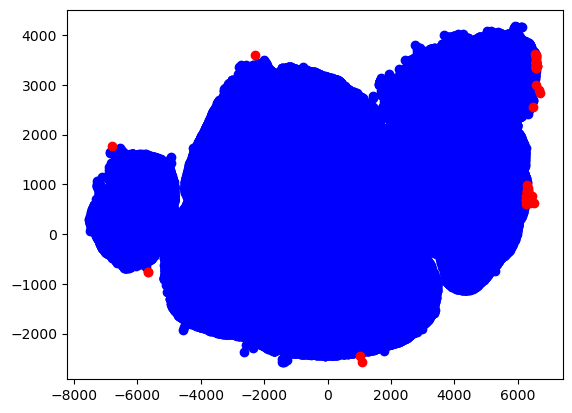

In [96]:
# show where the NAs are
slice_id = 'sa1_slice10'
test_slice = cmd[cmd['slice_id'] == slice_id]
test_slice_not_NA = test_slice[~test_slice.ccfx.isna()]
test_slice_NA = test_slice[test_slice.ccfx.isna()]

plt.scatter(test_slice_not_NA.center_x, test_slice_not_NA.center_y, color = 'b')
plt.scatter(test_slice_NA.center_x, test_slice_NA.center_y, color = 'r')

In [97]:
# careful here
# lets just remove space module for now
#cmd = cmd.drop('spatial_modules_level_1_name', axis = 1)
#cmd.dropna(inplace = True)

cmd = cmd[~cmd.ccfx.isna()]
len(cmd)

2560520

In [98]:
# get rid of old stored values?
if np.any(cmd.columns.isin(['ccfx_2', 'ccfy_2', 'ccfz_2', 'annotation_2'])):
    cmd.drop(columns=['ccfx_2', 'ccfy_2', 'ccfz_2', 'annotation_2'], inplace = True)

z = cmd.ccfx.values/ccf_pixel_size
y = cmd.ccfy.values/ccf_pixel_size
x = cmd.ccfz.values/ccf_pixel_size
cells_pos = np.array([x, y, z]).T #

# write the files to the disk
write_pts_file(cells_pos)

In [99]:
# warp the points
transformixImageFilter = sitk.TransformixImageFilter()
transformixImageFilter.SetTransformParameterMap(trans)
transformixImageFilter.SetMovingImage(sitk.GetImageFromArray(moving_1))
transformixImageFilter.SetFixedPointSetFileName('points.pts')
transformixImageFilter.Execute()

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x0000022219D52300> >

In [100]:
# read back the transformed points
output_points = read_outputpoints_file()
cells_pos_moving = output_points[:,3]

In [101]:
xloc = cells_pos_moving[:,0]
yloc = cells_pos_moving[:,1]
zloc = cells_pos_moving[:,2]

cells_pos_select = ((zloc.astype(int) < annot.shape[0] - 1) & (zloc.astype(int) >= 0) &
                    (yloc.astype(int) < annot.shape[1] - 1) & (yloc.astype(int) >= 0) &
                    (xloc.astype(int) < annot.shape[2] - 1) & (xloc.astype(int) >= 0))

xloc = xloc[cells_pos_select]
yloc = yloc[cells_pos_select]
zloc = zloc[cells_pos_select]

cells_annotations = annot[zloc.astype(int), yloc.astype(int), xloc.astype(int)]

idx = cmd.index[cells_pos_select]
cmd.loc[idx, 'ccfx_2'] = zloc * ccf_pixel_size
cmd.loc[idx, 'ccfy_2'] = yloc * ccf_pixel_size
cmd.loc[idx, 'ccfz_2'] = xloc * ccf_pixel_size
cmd.loc[cmd.index, 'annotation_2'] = np.nan # be careful here assigning NAN as default value.. is this smart?
cmd.loc[idx, 'annotation_2'] = cells_annotations

In [102]:
# save it?
cmd.to_csv('wb3_sa_all_ccf3d.csv', index = True)

### display registration results

In [103]:
annot_10, header = nrrd.read(ara_annot_10_file, index_order='C')
annot_10 = annot_10[570:,:,:] # take only one hemisphere
print(annot_10.shape)

(570, 800, 1320)


In [104]:
# this is for a curved boundary from 3D registration

def get_curved_border(cmd_subset, border_image3d, pixsize = 10, expand = 20, reflect = True):
    cmd_subset = cmd_subset.dropna()
    imdim = border_image3d[0].shape
    z_contour = np.zeros(imdim, dtype = np.uint16)
    y = (cmd_subset.ccfy_2/pixsize).astype(int)
    x = (cmd_subset.ccfz_2/pixsize).astype(int)
    z_contour[y,x] = (cmd_subset.ccfx_2/pixsize).astype(int)
    z_contour = skimage.segmentation.expand_labels(z_contour, expand)
    yy, xx = np.mgrid[0:imdim[0], 0:imdim[1]]
    output = border_image3d[z_contour, yy, xx]
    mask = z_contour > 0
    output[~mask] = 0
    if reflect:
        center = int(imdim[1]/2)
        output[:,center:] = output[:,center:0:-1]
    return output

# this is for a 2D registration

def get_2D_border(cmd_subset, border_image3d, pixsize = 10, expand = 20, reflect = True):
    cmd_subset = cmd_subset.dropna()
    imdim = border_image3d[0].shape
    z_contour = np.zeros(imdim, dtype = np.uint16)
    y = (cmd_subset.ccfy/pixsize).astype(int)
    x = (cmd_subset.ccfz/pixsize).astype(int)
    z_contour[y,x] = (cmd_subset.ccfx/pixsize).astype(int)
    z_contour = skimage.segmentation.expand_labels(z_contour, expand)
    yy, xx = np.mgrid[0:imdim[0], 0:imdim[1]]
    output = border_image3d[z_contour, yy, xx]
    mask = z_contour > 0
    output[~mask] = 0
    if reflect:
        center = int(imdim[1]/2)
        output[:,center:] = output[:,center:0:-1]
    return output

# add boundaries between regions
# added gaussian smoothing (set to zero for no smoothing)
def make_vector_outlines(im, smoothing = 1.5, threshhold = 0.5):
    output = []
    vals = np.unique(im)[1::] # this one drops the zero value
    for v in vals:
        mask = (im == v)
        if smoothing == 0:
            mask_contour = skimage.measure.find_contours(mask, 0.99)
        else:
            mask = skimage.filters.gaussian(mask, sigma = smoothing)
            mask_contour = skimage.measure.find_contours(mask, threshhold)
        output.append(mask_contour)
    output = [item for sublist in output for item in sublist]
    return output

In [105]:
%matplotlib qt

In [109]:
cmd_temp = cmd[cmd.slice_id == "sa1_slice1"]

curved = get_curved_border(cmd_temp, annot_10, pixsize = 10, expand = 30, reflect = False)

outlines = make_vector_outlines(curved, smoothing = 1)

# save as svg, eps or pdf for vector
fig = plt.figure()
plt.scatter(cmd_temp.ccfz_2/10, cmd_temp.ccfy_2/10, s = 1, c = cmd_temp.lvl2_colors)    
for outline in outlines:
    plt.plot(*np.flip(outline.T), 'k')
ax = plt.gca()
ax.set_ylim(0,800)
ax.set_xlim(0,1320)
ax.invert_yaxis()
#fig.savefig('outlines_smoothed.svg')

In [432]:
borders_2d = get_2D_border(cmd_temp, annot_10, pixsize = 10, expand = 30, reflect = False)
outlines = make_vector_outlines(borders_2d, smoothing = 1)

fig = plt.figure()
plt.scatter(cmd_temp.ccfz/10, cmd_temp.ccfy/10, s = .5, c = cmd_temp.lvl2_colors)
for outline in outlines:
    plt.plot(*np.flip(outline.T), 'k')
ax = plt.gca()
ax.set_ylim(0,800)
ax.set_xlim(0,1320)
ax.invert_yaxis()
ax.set_aspect('equal')
#plt.xticks([])
#plt.yticks([])
plt.axis('off')
plt.tight_layout()
#fig.savefig('test.png', transparent = True, dpi = 300)

In [110]:
# assemble and order all the slice ids
slice_ids = cmd.slice_id.unique()
slide_ids_order = np.argsort([int(sid[9:]) for sid in slice_ids])
slice_ids = slice_ids[slide_ids_order]
slice_ids

array(['sa2_slice1', 'sa1_slice1', 'sa2_slice2', 'sa1_slice2',
       'sa1_slice3', 'sa2_slice3', 'sa1_slice4', 'sa1_slice5',
       'sa1_slice6', 'sa1_slice7', 'sa1_slice8', 'sa1_slice9',
       'sa1_slice10', 'sa1_slice11', 'sa1_slice12', 'sa1_slice13',
       'sa1_slice14', 'sa1_slice15', 'sa1_slice16', 'sa1_slice17',
       'sa1_slice18', 'sa1_slice19', 'sa1_slice20', 'sa1_slice21',
       'sa1_slice22', 'sa1_slice23', 'sa1_slice24'], dtype=object)

In [113]:
transparent = False

plt.ioff()

for sid in slice_ids:
    print('working on slice id {}'.format(sid), end = '\r')
    cmd_temp = cmd[cmd.slice_id == sid]
    curve = get_curved_border(cmd_temp, annot_10, pixsize = 10, expand = 30, reflect = False)
    outlines = make_vector_outlines(curve, smoothing = 1)
    
    fig = plt.figure(figsize = [7,10])
    plt.scatter(cmd_temp.ccfz_2/10, cmd_temp.ccfy_2/10, s = .5, c = cmd_temp.lvl2_colors)
    for outline in outlines:
        plt.plot(*np.flip(outline.T), 'k')
    ax = plt.gca()
    ax.set_ylim(0,800)
    ax.set_xlim(0,1320)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    plt.axis('off')
    plt.tight_layout()
    fig.savefig('{} 3d reg.png'.format(sid), transparent = transparent, dpi = 300)
    plt.close()
plt.ion()

In [112]:
transparent = False

plt.ioff()

for sid in slice_ids:
    print('working on slice id {}'.format(sid), end = '\r')
    cmd_temp = cmd[cmd.slice_id == sid]
    curve = get_2D_border(cmd_temp, annot_10, pixsize = 10, expand = 30, reflect = False)
    outlines = make_vector_outlines(curve, smoothing = 1)
    
    fig = plt.figure(figsize = [7,10])
    plt.scatter(cmd_temp.ccfz/10, cmd_temp.ccfy/10, s = .5, c = cmd_temp.lvl2_colors)
    for outline in outlines:
        plt.plot(*np.flip(outline.T), 'k')
    ax = plt.gca()
    ax.set_ylim(0,800)
    ax.set_xlim(0,1320)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    plt.axis('off')
    plt.tight_layout()
    fig.savefig('{} 2d reg.png'.format(sid), transparent = transparent, dpi = 300)
    plt.close()

plt.ion()

### ### Transform annotated image back to MERFISH space

In [288]:
if True:
    cmd = pd.read_csv(r'wb3_sa_all_ccf3d.csv')
    cmd.set_index('cell_id', inplace = True)

In [114]:
len(cmd)

2560520

In [115]:
cmd.slice_id.unique()

array(['sa1_slice23', 'sa1_slice24', 'sa1_slice16', 'sa1_slice17',
       'sa1_slice10', 'sa1_slice8', 'sa1_slice3', 'sa1_slice4',
       'sa1_slice1', 'sa1_slice15', 'sa1_slice18', 'sa1_slice2',
       'sa1_slice22', 'sa1_slice11', 'sa1_slice14', 'sa1_slice19',
       'sa1_slice5', 'sa1_slice6', 'sa1_slice12', 'sa1_slice21',
       'sa1_slice7', 'sa1_slice13', 'sa1_slice20', 'sa1_slice9',
       'sa2_slice2', 'sa2_slice3', 'sa2_slice1'], dtype=object)

In [116]:
cmd.columns

Index(['fov', 'volume', 'center_x', 'center_y', 'sample_id', 'slice_id',
       'fov_x', 'fov_y', 'integration_partition_transfer',
       'integration_partition_confidence', 'subclass_label_transfer',
       'subclass_label_confidence', 'cl_transfer', 'cl_confidence',
       'cluster_cosine_similarity', 'adjusted_subclass_label_confidence',
       'adjusted_cl_confidence', 'spatial_modules_level_1', 'sm1_color',
       'local_color', 'spatial_modules_level_1_name', 'sm1n_color',
       'lvl2_colors', 'ccfx', 'ccfy', 'ccfz', 'annotation', 'note', 'ccfx_2',
       'ccfy_2', 'ccfz_2', 'annotation_2'],
      dtype='object')

In [117]:
# add boundaries between regions
# added gaussian smoothing (set to zero for no smoothing)
def make_vector_outlines(im, smoothing = 1.5, threshhold = 0.5, scale = 1, border = 1):
    output = []
    
    # clear the edge 
    im[0:border] = 0
    im[-border:] = 0
    im[:,0:border] = 0
    im[:,-border:] = 0
    
    vals = np.unique(im)[1::] # this one drops the zero value
    for v in vals:
        mask = (im == v)
        if smoothing == 0:
            mask_contour = skimage.measure.find_contours(mask, 0.99)
        else:
            mask = skimage.filters.gaussian(mask, sigma = smoothing)
            mask_contour = skimage.measure.find_contours(mask, threshhold)
        output.append(mask_contour)
    output = [item * scale for sublist in output for item in sublist]
    return output

# add boundaries between regions
# added gaussian smoothing (set to zero for no smoothing)
def make_vector_outlines_dict(im, smoothing = 1.5, threshhold = 0.5, scale = 1, border = 1):
    output = {}

    # clear the edge 
    im[0:border] = 0
    im[-border:] = 0
    im[:,0:border] = 0
    im[:,-border:] = 0
    
    vals = np.unique(im)[1::] # this one drops the zero value
    for v in vals:
        mask = (im == v)
        if smoothing == 0:
            mask_contour = skimage.measure.find_contours(mask, 0.99)
        else:
            mask = skimage.filters.gaussian(mask, sigma = smoothing)
            mask_contour = skimage.measure.find_contours(mask, threshhold)
            
        if len(mask_contour) > 0:
            output[v] = [contour * scale for contour in mask_contour]
    return output

In [118]:
def convert_outlines_to_merlin(df, index, cmd, outlines_dict, ccf_pixel_size = 25, bbox = None, pad_width = 20):
    file = df.iloc[index].Filename
    rot = df.iloc[index].rot_init
    reflect = df.iloc[index].reflect
    scale_x, scale_y = [df.iloc[index].scale_x, df.iloc[index].scale_y]
    dataname, slicenum, y1, y2, x1, x2 = parse_filename(file)
    # need to know some stuff about the raw image
    imraw = skimage.io.imread(file)
    imdim = np.array(imraw.shape)
    imcenter = find_center(imraw)
    umperpixY = (y2-y1)/imdim[0]
    umperpixX = (x2-x1)/imdim[1]
    
    # here is the cell metadata subset
    cmd_temp = cmd[cmd.sample_id == df.iloc[index].cell_metadata]
    
    cells =  cmd_temp[(y1 < cmd_temp['center_y']) &
              (cmd_temp['center_y'] < y2) & 
              (x1 < cmd_temp['center_x']) & 
              (cmd_temp['center_x'] < x2)].copy() # make a copy so it does not give the slice warning...
    
    tform1 = mat_trans(-x1,-y1) # move the corner of the image to the origin
    tform2 = mat_scale(1/umperpixX, 1/umperpixY) # scale the image into pixels
    tform3 = mat_trans(imcenter[1],imcenter[0]) @ mat_rot(-rot) @ mat_trans(-imcenter[1],-imcenter[0]) # do initial rotation (translated to the center, rotate, translate back)
    shiftr, shiftc, out_rows, out_cols = find_new_corner(imdim[0], imdim[1], -rot) # find the new size of the image since it was rotated
    tform4 = mat_trans(-shiftc,-shiftr) # shift to the new corner
    tform5 = mat_reflect(reflect = reflect, dx = out_cols) # reflect if there is a reflection
    tform6 = mat_scale(scale_x,scale_y) # do final scaling in x and y which was added for better registration
    tform7 = mat_trans(-bbox[1],-bbox[0]) # crop in on the cells
    tform8 = mat_trans(pad_width,pad_width) # add padding
    tform =  tform8 @ tform7 @ tform6 @ tform5 @ tform4 @ tform3 @ tform2 @ tform1 # final transform of everything!
    
    # we will invert the transform here since we want to move back to MERLIN space
    tform = np.linalg.inv(tform)
    
    cells_pos_merlin = np.array([cells['center_x'], cells['center_y']]).T

    outlines_transformed = {}
    for key, outlines in outlines_dict.items():
        new_outlines = []
        for outline in outlines:
            new_outlines.append(transform_positions(tform, np.flip(outline, axis = 1)))
            
        outlines_transformed[key] = new_outlines

    return outlines_transformed, cells_pos_merlin, cells

In [119]:
def convert_outlines_to_fixed(df, index, cmd, outlines_dict, ccf_pixel_size = 25, bbox = None, pad_width = 20):
    file = df.iloc[index].Filename
    rot = df.iloc[index].rot_init
    reflect = df.iloc[index].reflect
    scale_x, scale_y = [df.iloc[index].scale_x, df.iloc[index].scale_y]
    dataname, slicenum, y1, y2, x1, x2 = parse_filename(file)
    # need to know some stuff about the raw image
    imraw = skimage.io.imread(file)
    imdim = np.array(imraw.shape)
    imcenter = find_center(imraw)
    umperpixY = (y2-y1)/imdim[0]
    umperpixX = (x2-x1)/imdim[1]
    
    # here is the cell metadata subset
    cmd_temp = cmd[cmd.sample_id == df.iloc[index].cell_metadata]
    
    cells =  cmd_temp[(y1 < cmd_temp['center_y']) &
                  (cmd_temp['center_y'] < y2) & 
                  (x1 < cmd_temp['center_x']) & 
                  (cmd_temp['center_x'] < x2)].copy() # make a copy so it does not give the slice warning...
    
    tform1 = mat_trans(-x1,-y1) # move the corner of the image to the origin
    tform2 = mat_scale(1/umperpixX, 1/umperpixY) # scale the image into pixels
    tform3 = mat_trans(imcenter[1],imcenter[0]) @ mat_rot(-rot) @ mat_trans(-imcenter[1],-imcenter[0]) # do initial rotation (translated to the center, rotate, translate back)
    shiftr, shiftc, out_rows, out_cols = find_new_corner(imdim[0], imdim[1], -rot) # find the new size of the image since it was rotated
    tform4 = mat_trans(-shiftc,-shiftr) # shift to the new corner
    tform5 = mat_reflect(reflect = reflect, dx = out_cols) # reflect if there is a reflection
    
    # convert to microns?
    tform_um = mat_scale(umperpixX, umperpixY) 
    
    tform =  tform_um @ tform5 @ tform4 @ tform3 @ tform2 @ tform1
    
    cells_pos = np.array([cells['center_x'], cells['center_y']]).T
    cells_pos_image_space = transform_positions(tform, cells_pos) # transform the cell positions from the initial transforms
    cells['fixed_x'] = cells_pos_image_space[:,0]
    cells['fixed_y'] = cells_pos_image_space[:,1]
    
    # transforming contours
    
    tform6 = mat_scale(scale_x,scale_y) # do final scaling in x and y which was added for better registration
    tform7 = mat_trans(-bbox[1],-bbox[0]) # crop in on the cells
    tform8 = mat_trans(pad_width,pad_width) # add padding
    tform_rev =  tform8 @ tform7 @ tform6
    
    tform_rev = tform8 @ tform7 @ tform6
    tform_rev = np.linalg.inv(tform_rev)

    # convert to microns?
    tform_rev = tform_um @ tform_rev
    
    outlines_transformed = {}
    for key, outlines in outlines_dict.items():
        new_outlines = []
        for outline in outlines:
            new_outlines.append(transform_positions(tform_rev, np.flip(outline, axis = 1)))
            
        outlines_transformed[key] = new_outlines

    return outlines_transformed, cells_pos_image_space, cells

In [120]:
cmd_temp = cmd[cmd.sample_id == df.iloc[1].cell_metadata]
cmd_temp.columns

Index(['fov', 'volume', 'center_x', 'center_y', 'sample_id', 'slice_id',
       'fov_x', 'fov_y', 'integration_partition_transfer',
       'integration_partition_confidence', 'subclass_label_transfer',
       'subclass_label_confidence', 'cl_transfer', 'cl_confidence',
       'cluster_cosine_similarity', 'adjusted_subclass_label_confidence',
       'adjusted_cl_confidence', 'spatial_modules_level_1', 'sm1_color',
       'local_color', 'spatial_modules_level_1_name', 'sm1n_color',
       'lvl2_colors', 'ccfx', 'ccfy', 'ccfz', 'annotation', 'note', 'ccfx_2',
       'ccfy_2', 'ccfz_2', 'annotation_2'],
      dtype='object')

In [121]:
# load in the high resolution annotated image
# note time stamp of when it was generated
annot_3d = skimage.io.imread(r'moving_3D_spline_10_1690729879.tif')
annot_3d = np.rint(annot_3d).astype(np.uint32)

annot_3d = annot_3d[:,:,:-int(10 * 2.5)] # remove the pad

annot_3d.shape

(570, 800, 1320)

In [122]:
# make sure this is the same size
np.array(annot.shape) * 2.5

array([ 570.,  800., 1320.])

In [123]:
%matplotlib qt

In [124]:
# Test one slice

slice_to_register = 10

print('start register slice {}'.format(slice_to_register))

num = slice_to_register - 1

df = import_df(slice_info_filename)
ccf_pixel_size = 25

allen_slice_num = df.iloc[num].allen_slice_num
allen_slice_num_10 = int(allen_slice_num * 2.5)
filename = df.iloc[num].Filename

rescale_percent = 0.99

moving_annot = annot[allen_slice_num]
moving_borders = borders[allen_slice_num]
nissl_im = nissl[allen_slice_num]

### first do the no olf bulb part ###

fixed, _, fixed_mask_1, _ = modify_dapi(df, num, cmd,
    cell_types = df.iloc[num].cell_types,
    space_modules = df.iloc[num].space_modules,
    cell_types_to_remove = df.iloc[num].cell_types_to_remove,
    factor = df.iloc[num].dapi_enhance_factor)

moving, _  = modify_nissl(nissl_im, moving_annot,
    annot_dict = df.iloc[num].annots_to_amplify,
    remove_list = df.iloc[num].annots_to_remove,
    factor = df.iloc[num].nissl_enhance_factor)

output_10 = np.zeros((np.array(fixed.shape) * 2.5).astype(int))

# make some params
csv_file = os.path.splitext(filename)[0] + 'no_olf.csv'
fix_points = None
if os.path.exists(csv_file):
    print(csv_file)
    p, p2 = params_from_df(df, num, cor_pts = True)
    
    print('corresponding points found')
    cor_points = pd.read_csv(csv_file)
    fix_points = cor_points[['fix_x', 'fix_y']].values
    mov_points = cor_points[['mov_x', 'mov_y']].values
    
    write_pts_file(fix_points, name = 'fix.pts')
    write_pts_file(mov_points, name = 'mov.pts')
else:
    p, p2 = params_from_df(df, num)

pad_width = df.iloc[num].pad_width
print('pad width set to {}'.format(pad_width))
# probably should jsut fix the aspect ratio issue which was a legacy from similarty transform

# crop images (may not be necessary since we did it already) and add a pad
_, _, fixed_mask_1, = crop_and_pad_image(fixed, fixed_mask_1, pad_width = pad_width, area_thresh = 300)
fix_bbox, fixed, _ = crop_and_pad_image(fixed, pad_width = pad_width, area_thresh = 300)
_, _, moving_borders = crop_and_pad_image(moving, moving_borders, pad_width = pad_width, area_thresh = 300) # be careful here don't overwrite the original moving...
mov_bbox, moving, moving_annot = crop_and_pad_image(moving, moving_annot, pad_width = pad_width, area_thresh = 300) 

# making the high res annotated image
# here is the slice from the 3d registration
annot_3d_slice = annot_3d[allen_slice_num_10]

mov_bbox_10 = (np.array(mov_bbox) * 2.5).astype(int)
annot_3d_slice = np.pad(annot_3d_slice[mov_bbox_10[0]:mov_bbox_10[2],mov_bbox_10[1]:mov_bbox_10[3]], int(2.5*pad_width))

print('slice num {}'.format(df.iloc[num].Slice))
print('allen slice {}'.format(allen_slice_num))
print('registering OB-')

# register a slice to allen

trans, moving_spline = register_images(fixed, moving, p, p2)

# transform other images
moving_rigid = transform_image(moving, trans[0])
moving_annot_rigid = annot_revert[transform_image(annot_convert[moving_annot], trans[0], interpolation = False).astype(np.uint32)]
moving_annot_spline = annot_revert[transform_image(annot_convert[moving_annot], trans, interpolation = False).astype(np.uint32)]
moving_borders_spline = transform_image(moving_borders, trans, interpolation = True)

fixed_10_shape = (np.array(fixed.shape) * 2.5).astype(int)
fixed_mask_1_10 = skimage.transform.resize(fixed_mask_1, fixed_10_shape) 
fix_bbox_1_10 = (np.array(fix_bbox) * 2.5).astype(int)

trans_10 = copy.copy(trans)
for tran in trans_10:
    tran['Size'] = L2P(np.flip(fixed_10_shape)) # It looks like this is actually supposed to be the fixed image size
    tran['Spacing'] = L2P([0.4,0.4])

annot_3d_slice_1 = np.copy(annot_3d_slice)
annot_3d_slice_spline_1 = annot_revert[transform_image(annot_convert[annot_3d_slice_1], trans_10, interpolation = False, spacing = (0.4,0.4)).astype(np.uint32)]

### then do olf bulb part ###

moving_annot = annot[allen_slice_num]
moving_borders = borders[allen_slice_num]
nissl_im = nissl[allen_slice_num]

_, fixed, _, fixed_mask_2 = modify_dapi(df, num, cmd,
    cell_types = df.iloc[num].cell_types,
    space_modules = df.iloc[num].space_modules,
    cell_types_to_remove = df.iloc[num].cell_types_to_remove,
    factor = df.iloc[num].dapi_enhance_factor)

_, moving  = modify_nissl(nissl_im, moving_annot,
    annot_dict = df.iloc[num].annots_to_amplify_alt,
    remove_list = df.iloc[num].annots_to_remove,
    factor = df.iloc[num].nissl_enhance_factor)

# make some params
csv_file = os.path.splitext(filename)[0] + '_olf.csv'
fix_points = None
if os.path.exists(csv_file):
    print(csv_file)
    p, p2 = params_from_df(df, num, cor_pts = True)
    
    print('corresponding points found')
    cor_points = pd.read_csv(csv_file)
    fix_points = cor_points[['fix_x', 'fix_y']].values
    mov_points = cor_points[['mov_x', 'mov_y']].values
    
    write_pts_file(fix_points, name = 'fix.pts')
    write_pts_file(mov_points, name = 'mov.pts')
else:
    p, p2 = params_from_df(df, num)

# crop and pad images
pad_width = df.iloc[num].pad_width
print('pad width set to {}'.format(pad_width))
# probably should jsut fix the aspect ratio issue which was a legacy from similarty transform

# crop images (may not be necessary since we did it already) and add a pad
_, _, fixed_mask_2, = crop_and_pad_image(fixed, fixed_mask_2, pad_width = pad_width, area_thresh = 300)
fix_bbox, fixed, _ = crop_and_pad_image(fixed, pad_width = pad_width, area_thresh = 300)
_, _, moving_borders = crop_and_pad_image(moving, moving_borders, pad_width = pad_width, area_thresh = 300) # be careful here don't overwrite the original moving...
mov_bbox, moving, moving_annot = crop_and_pad_image(moving, moving_annot, pad_width = pad_width, area_thresh = 300) 

# making the high res annotated image
# here is the slice from the 3d registration
annot_3d_slice = annot_3d[allen_slice_num_10]

mov_bbox_10 = (np.array(mov_bbox) * 2.5).astype(int)
annot_3d_slice = np.pad(annot_3d_slice[mov_bbox_10[0]:mov_bbox_10[2],mov_bbox_10[1]:mov_bbox_10[3]], int(2.5*pad_width))

print('slice num {}'.format(df.iloc[num].Slice))
print('allen slice {}'.format(allen_slice_num))
print('registering OB+')

# register a slice to allen

trans, moving_spline = register_images(fixed, moving, p, p2)

# transform other images
moving_rigid = transform_image(moving, trans[0])
moving_annot_rigid = annot_revert[transform_image(annot_convert[moving_annot], trans[0], interpolation = False).astype(np.uint32)]
moving_annot_spline = annot_revert[transform_image(annot_convert[moving_annot], trans, interpolation = False).astype(np.uint32)]
moving_borders_spline = transform_image(moving_borders, trans, interpolation = True)

fixed_10_shape = (np.array(fixed.shape) * 2.5).astype(int)
fix_bbox_2_10 = (np.array(fix_bbox) * 2.5).astype(int)

trans_10 = copy.copy(trans)
for tran in trans_10:
    tran['Size'] = L2P(np.flip(fixed_10_shape)) # It looks like this is actually supposed to be the fixed image size
    tran['Spacing'] = L2P([0.4,0.4])

annot_3d_slice_2 = np.copy(annot_3d_slice)
annot_3d_slice_spline_2 = annot_revert[transform_image(annot_convert[annot_3d_slice_2], trans_10, interpolation = False, spacing = (0.4,0.4)).astype(np.uint32)]

### add them together for the final result
### this is a kind of a painful way of doing it...
pad = int(2.5 * pad_width)

# filtering of OB
output_2 = np.pad(output_10, pad)
#annot_3d_slice_spline_2 = annot_3d_slice_spline_2[pad:-pad,pad:-pad]
w, h = annot_3d_slice_spline_2.shape
r = int(fix_bbox_2_10[0])
c = int(fix_bbox_2_10[1])
output_2[r:r+w,c:c+h] = annot_3d_slice_spline_2
output_2 = output_2[pad:-pad,pad:-pad]

merge_annots = [159,900,597,605]
remove_2 = np.isin(output_2, df.iloc[num].annots_to_remove + merge_annots) 
output_2[~remove_2] = 0

# filtering of non-OB
output_1 = output_10.copy()
annot_3d_slice_spline_1 = annot_3d_slice_spline_1
annot_3d_slice_spline_1 = annot_3d_slice_spline_1[pad:-pad,pad:-pad]
w, h = annot_3d_slice_spline_1.shape
r = int(fix_bbox_1_10[0])
c = int(fix_bbox_1_10[1])
output_1[r:r+w,c:c+h] = annot_3d_slice_spline_1

# dealing with 698 is annoying
mask_698 = (output_1 == 698)
mask_698[:,:250] = False
mask_698[np.logical_and(mask_698, output_2 > 0)] = 0

# remove annotations that should not be there
remove_1 = np.isin(output_1, df.iloc[num].annots_to_remove) 
output_1[remove_1] = 0
output_1[mask_698] = 698

output_10 += output_2
output_10[output_1 > 0] = 0
output_10 += output_1

annot_3d_slice_spline = output_10


# Make the vector outlines

outlines_dict = make_vector_outlines_dict(annot_3d_slice_spline, smoothing = 1, threshhold = 0.5, scale = 0.4)


# cells and outlines in merlin space
fig3, ax = plt.subplots(1,1)
outlines_merlin_dict, cell_pos_merlin, cells = convert_outlines_to_merlin(df, num, cmd, outlines_dict,
                                                                 ccf_pixel_size = ccf_pixel_size,
                                                                 bbox = [0,0],
                                                                 pad_width = 0)

for key, outlines in outlines_merlin_dict.items():
    for outline in outlines:
        ax.plot(*outline.T, 'k')   
ax.scatter(cell_pos_merlin[:,0],cell_pos_merlin[:,1], s = 0.3, c = cells['lvl2_colors'])

# cells and outlines in fixed space
fig4, ax = plt.subplots(1,1)
outlines_fixed_dict, cell_pos_fixed, cells = convert_outlines_to_fixed(df, num, cmd, outlines_dict,
                                                                 ccf_pixel_size = ccf_pixel_size,
                                                                 bbox = [0,0],
                                                                 pad_width = 0)

for key, outlines in outlines_fixed_dict.items():
    for outline in outlines:
        ax.plot(*outline.T, 'k')   
ax.scatter(cell_pos_fixed[:,0],cell_pos_fixed[:,1], s = 0.3, c = cells['lvl2_colors'], edgecolor = None)
ax.invert_yaxis()

# cells and tiff in fixed space
fig5, ax = plt.subplots(1,1)

fixed_im = annot_3d_slice_spline
fixed_im = np.rint(fixed_im).astype(np.uint32)
sizey, sizex = fixed_im.shape
sizex2 = int(np.rint(sizex / df.iloc[num].scale_x))
sizey2 = int(np.rint(sizey / df.iloc[num].scale_y))
annot_3d_slice_spline_fixed = skimage.transform.resize(fixed_im,
                                                       (sizey2, sizex2),
                                                       preserve_range = True,
                                                       order = 0).astype(np.uint32)

ax.scatter(cell_pos_fixed[:,0]/10,cell_pos_fixed[:,1]/10, s = 0.3, c = cells['lvl2_colors'], edgecolor = None)
ax.imshow(annot_3d_slice_spline_fixed, cmap = 'gray', vmin = 0, vmax = 1000)

slice_id = cells.slice_id.value_counts().index[0]
print(slice_id)

skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)

# save these coordinates to the cmd dataframe
cmd.loc[cells.index, 'fixed_x'] = cell_pos_fixed[:,0]
cmd.loc[cells.index, 'fixed_y'] = cell_pos_fixed[:,1]

fig3.savefig('{}_merlin_space.png'.format(slice_id))
fig4.savefig('{}_fixed_space.png'.format(slice_id))

print('done')

start register slice 10
220506_sa_10_merfish4_adaptor_5z18r_slice0_y_-002602_004221_x_-007679_006743_25um_pixno_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 10.0
allen slice 82
registering OB-
load corresponding points
SITK spacing set to (0.4, 0.4)


C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3977407013.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_1 = np.logical_and(annot == val, output > 0)
C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3977407013.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_2 = np.logical_and(annot == val, output_inverse > 0)


220506_sa_10_merfish4_adaptor_5z18r_slice0_y_-002602_004221_x_-007679_006743_25um_pix_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 10.0
allen slice 82
registering OB+
load corresponding points
SITK spacing set to (0.4, 0.4)
sa1_slice10
done


In [102]:
#skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)

C:\Users\aaron\AppData\Local\Temp\ipykernel_13920\447674286.py:1: UserWarning: sa1_slice3_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


In [125]:
%matplotlib qt

## Loop that combines both bulb and no bulb

In [126]:
istart = 1 #1
istop = 11 #11
rescale_percent = 0.99

matplotlib.use('Agg')

slices_to_register = np.arange(istart,istop).astype(int)

for slice_to_register in slices_to_register:
    num = slice_to_register - 1
    
    print('working on slice {}/{}'.format(slice_to_register,slices_to_register[-1]))

    df = import_df(slice_info_filename)
    ccf_pixel_size = 25

    allen_slice_num = df.iloc[num].allen_slice_num
    allen_slice_num_10 = int(allen_slice_num * 2.5)
    filename = df.iloc[num].Filename

    rescale_percent = 0.99

    moving_annot = annot[allen_slice_num]
    moving_borders = borders[allen_slice_num]
    nissl_im = nissl[allen_slice_num]

    ### first do the no olf bulb part ###

    fixed, _, fixed_mask_1, _ = modify_dapi(df, num, cmd,
        cell_types = df.iloc[num].cell_types,
        space_modules = df.iloc[num].space_modules,
        cell_types_to_remove = df.iloc[num].cell_types_to_remove,
        factor = df.iloc[num].dapi_enhance_factor)

    moving, _  = modify_nissl(nissl_im, moving_annot,
        annot_dict = df.iloc[num].annots_to_amplify,
        remove_list = df.iloc[num].annots_to_remove,
        factor = df.iloc[num].nissl_enhance_factor)

    output_10 = np.zeros((np.array(fixed.shape) * 2.5).astype(int))

    # make some params
    csv_file = os.path.splitext(filename)[0] + 'no_olf.csv'
    fix_points = None
    if os.path.exists(csv_file):
        print(csv_file)
        p, p2 = params_from_df(df, num, cor_pts = True)

        print('corresponding points found')
        cor_points = pd.read_csv(csv_file)
        fix_points = cor_points[['fix_x', 'fix_y']].values
        mov_points = cor_points[['mov_x', 'mov_y']].values

        write_pts_file(fix_points, name = 'fix.pts')
        write_pts_file(mov_points, name = 'mov.pts')
    else:
        p, p2 = params_from_df(df, num)
    
    # crop and pad images
    pad_width = df.iloc[num].pad_width
    print('pad width set to {}'.format(pad_width))
    # probably should just fix the aspect ratio issue which was a legacy from similarty transform

    # crop images (may not be necessary since we did it already) and add a pad
    _, _, fixed_mask_1, = crop_and_pad_image(fixed, fixed_mask_1, pad_width = pad_width, area_thresh = 300)
    fix_bbox, fixed, _ = crop_and_pad_image(fixed, pad_width = pad_width, area_thresh = 300)
    _, _, moving_borders = crop_and_pad_image(moving, moving_borders, pad_width = pad_width, area_thresh = 300) # be careful here don't overwrite the original moving...
    mov_bbox, moving, moving_annot = crop_and_pad_image(moving, moving_annot, pad_width = pad_width, area_thresh = 300) 

    # making the high res annotated image
    # here is the slice from the 3d registration
    annot_3d_slice = annot_3d[allen_slice_num_10]

    mov_bbox_10 = (np.array(mov_bbox) * 2.5).astype(int)
    annot_3d_slice = np.pad(annot_3d_slice[mov_bbox_10[0]:mov_bbox_10[2],mov_bbox_10[1]:mov_bbox_10[3]], int(2.5*pad_width))

    print('slice num {}'.format(df.iloc[num].Slice))
    print('allen slice {}'.format(allen_slice_num))
    print('registering OB-')

    # register a slice to allen

    trans, moving_spline = register_images(fixed, moving, p, p2)

    # transform other images
    moving_rigid = transform_image(moving, trans[0])
    moving_annot_rigid = annot_revert[transform_image(annot_convert[moving_annot], trans[0], interpolation = False).astype(np.uint32)]
    moving_annot_spline = annot_revert[transform_image(annot_convert[moving_annot], trans, interpolation = False).astype(np.uint32)]
    moving_borders_spline = transform_image(moving_borders, trans, interpolation = True)

    fixed_10_shape = (np.array(fixed.shape) * 2.5).astype(int)
    fixed_mask_1_10 = skimage.transform.resize(fixed_mask_1, fixed_10_shape) 
    fix_bbox_1_10 = (np.array(fix_bbox) * 2.5).astype(int)

    trans_10 = copy.copy(trans)
    for tran in trans_10:
        tran['Size'] = L2P(np.flip(fixed_10_shape)) # It looks like this is actually supposed to be the fixed image size
        tran['Spacing'] = L2P([0.4,0.4])

    annot_3d_slice_1 = np.copy(annot_3d_slice)
    annot_3d_slice_spline_1 = annot_revert[transform_image(annot_convert[annot_3d_slice_1], trans_10, interpolation = False, spacing = (0.4,0.4)).astype(np.uint32)]

    ### then do olf bulb part ###

    moving_annot = annot[allen_slice_num]
    moving_borders = borders[allen_slice_num]
    nissl_im = nissl[allen_slice_num]

    _, fixed, _, fixed_mask_2 = modify_dapi(df, num, cmd,
        cell_types = df.iloc[num].cell_types,
        space_modules = df.iloc[num].space_modules,
        cell_types_to_remove = df.iloc[num].cell_types_to_remove,
        factor = df.iloc[num].dapi_enhance_factor)

    _, moving  = modify_nissl(nissl_im, moving_annot,
        annot_dict = df.iloc[num].annots_to_amplify_alt,
        remove_list = df.iloc[num].annots_to_remove,
        factor = df.iloc[num].nissl_enhance_factor)

    # make some params
    csv_file = os.path.splitext(filename)[0] + '_olf.csv'
    fix_points = None
    if os.path.exists(csv_file):
        print(csv_file)
        p, p2 = params_from_df(df, num, cor_pts = True)

        print('corresponding points found')
        cor_points = pd.read_csv(csv_file)
        fix_points = cor_points[['fix_x', 'fix_y']].values
        mov_points = cor_points[['mov_x', 'mov_y']].values

        write_pts_file(fix_points, name = 'fix.pts')
        write_pts_file(mov_points, name = 'mov.pts')
    else:
        p, p2 = params_from_df(df, num)
    # crop and pad images

    pad_width = df.iloc[num].pad_width
    print('pad width set to {}'.format(pad_width))
    # probably should jsut fix the aspect ratio issue which was a legacy from similarty transform

    # crop images (may not be necessary since we did it already) and add a pad
    _, _, fixed_mask_2, = crop_and_pad_image(fixed, fixed_mask_2, pad_width = pad_width, area_thresh = 300)
    fix_bbox, fixed, _ = crop_and_pad_image(fixed, pad_width = pad_width, area_thresh = 300)
    _, _, moving_borders = crop_and_pad_image(moving, moving_borders, pad_width = pad_width, area_thresh = 300) # be careful here don't overwrite the original moving...
    mov_bbox, moving, moving_annot = crop_and_pad_image(moving, moving_annot, pad_width = pad_width, area_thresh = 300) 

    # making the high res annotated image
    # here is the slice from the 3d registration
    annot_3d_slice = annot_3d[allen_slice_num_10]

    mov_bbox_10 = (np.array(mov_bbox) * 2.5).astype(int)
    annot_3d_slice = np.pad(annot_3d_slice[mov_bbox_10[0]:mov_bbox_10[2],mov_bbox_10[1]:mov_bbox_10[3]], int(2.5*pad_width))

    print('slice num {}'.format(df.iloc[num].Slice))
    print('allen slice {}'.format(allen_slice_num))
    print('registering OB+')

    # register a slice to allen

    trans, moving_spline = register_images(fixed, moving, p, p2)

    # transform other images
    moving_rigid = transform_image(moving, trans[0])
    moving_annot_rigid = annot_revert[transform_image(annot_convert[moving_annot], trans[0], interpolation = False).astype(np.uint32)]
    moving_annot_spline = annot_revert[transform_image(annot_convert[moving_annot], trans, interpolation = False).astype(np.uint32)]
    moving_borders_spline = transform_image(moving_borders, trans, interpolation = True)

    fixed_10_shape = (np.array(fixed.shape) * 2.5).astype(int)
    fix_bbox_2_10 = (np.array(fix_bbox) * 2.5).astype(int)

    trans_10 = copy.copy(trans)
    for tran in trans_10:
        tran['Size'] = L2P(np.flip(fixed_10_shape)) # It looks like this is actually supposed to be the fixed image size
        tran['Spacing'] = L2P([0.4,0.4])

    annot_3d_slice_2 = np.copy(annot_3d_slice)
    annot_3d_slice_spline_2 = annot_revert[transform_image(annot_convert[annot_3d_slice_2], trans_10, interpolation = False, spacing = (0.4,0.4)).astype(np.uint32)]

    ### add them together for the final result
    ### this is a kind of a painful way of doing it...
    pad = int(2.5 * pad_width)

    # filtering of OB
    output_2 = np.pad(output_10, pad)
    #annot_3d_slice_spline_2 = annot_3d_slice_spline_2[pad:-pad,pad:-pad]
    w, h = annot_3d_slice_spline_2.shape
    r = int(fix_bbox_2_10[0])
    c = int(fix_bbox_2_10[1])
    output_2[r:r+w,c:c+h] = annot_3d_slice_spline_2
    output_2 = output_2[pad:-pad,pad:-pad]

    merge_annots = [159,900,597,605]
    remove_2 = np.isin(output_2, df.iloc[num].annots_to_remove + merge_annots) 
    output_2[~remove_2] = 0

    # filtering of non-OB
    output_1 = output_10.copy()
    annot_3d_slice_spline_1 = annot_3d_slice_spline_1
    annot_3d_slice_spline_1 = annot_3d_slice_spline_1[pad:-pad,pad:-pad]
    w, h = annot_3d_slice_spline_1.shape
    r = int(fix_bbox_1_10[0])
    c = int(fix_bbox_1_10[1])
    output_1[r:r+w,c:c+h] = annot_3d_slice_spline_1

    # dealing with 698 is annoying
    mask_698 = (output_1 == 698)
    mask_698[:,:250] = False
    mask_698[np.logical_and(mask_698, output_2 > 0)] = 0

    # remove annotations that should not be there
    remove_1 = np.isin(output_1, df.iloc[num].annots_to_remove) 
    output_1[remove_1] = 0
    output_1[mask_698] = 698

    output_10 += output_2
    output_10[output_1 > 0] = 0
    output_10 += output_1

    annot_3d_slice_spline = output_10


    # Make the vector outlines

    outlines_dict = make_vector_outlines_dict(annot_3d_slice_spline, smoothing = 1, threshhold = 0.5, scale = 0.4)


    # cells and outlines in merlin space
    fig3, ax = plt.subplots(1,1)
    outlines_merlin_dict, cell_pos_merlin, cells = convert_outlines_to_merlin(df, num, cmd, outlines_dict,
                                                                     ccf_pixel_size = ccf_pixel_size,
                                                                     bbox = [0,0],
                                                                     pad_width = 0)

    for key, outlines in outlines_merlin_dict.items():
        for outline in outlines:
            ax.plot(*outline.T, 'k')   
    ax.scatter(cell_pos_merlin[:,0],cell_pos_merlin[:,1], s = 0.3, c = cells['lvl2_colors'])

    # cells and outlines in fixed space
    fig4, ax = plt.subplots(1,1)
    outlines_fixed_dict, cell_pos_fixed, cells = convert_outlines_to_fixed(df, num, cmd, outlines_dict,
                                                                     ccf_pixel_size = ccf_pixel_size,
                                                                     bbox = [0,0],
                                                                     pad_width = 0)

    for key, outlines in outlines_fixed_dict.items():
        for outline in outlines:
            ax.plot(*outline.T, 'k')   
    ax.scatter(cell_pos_fixed[:,0],cell_pos_fixed[:,1], s = 0.3, c = cells['lvl2_colors'], edgecolor = None)
    ax.invert_yaxis()

    # cells and tiff in fixed space
    fig5, ax = plt.subplots(1,1)

    fixed_im = annot_3d_slice_spline
    fixed_im = np.rint(fixed_im).astype(np.uint32)
    sizey, sizex = fixed_im.shape
    sizex2 = int(np.rint(sizex / df.iloc[num].scale_x))
    sizey2 = int(np.rint(sizey / df.iloc[num].scale_y))
    annot_3d_slice_spline_fixed = skimage.transform.resize(fixed_im,
                                                           (sizey2, sizex2),
                                                           preserve_range = True,
                                                           order = 0).astype(np.uint32)

    ax.scatter(cell_pos_fixed[:,0]/10,cell_pos_fixed[:,1]/10, s = 0.3, c = cells['lvl2_colors'], edgecolor = None)
    ax.imshow(annot_3d_slice_spline_fixed, cmap = 'gray', vmin = 0, vmax = 1000)

    slice_id = cells.slice_id.value_counts().index[0]
    print(slice_id)

    skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)

    # save these coordinates to the cmd dataframe
    cmd.loc[cells.index, 'fixed_x'] = cell_pos_fixed[:,0]
    cmd.loc[cells.index, 'fixed_y'] = cell_pos_fixed[:,1]

    fig3.savefig('{}_merlin_space.png'.format(slice_id))
    fig4.savefig('{}_fixed_space.png'.format(slice_id))

    plt.close('all')

working on slice 1/10
220609_wb3_sa1_1_5z18R_merfish5_slice0_y_-002984_003238_x_-005648_007574_25um_pixno_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 1.0
allen slice 12
registering OB-
load corresponding points
SITK spacing set to (0.4, 0.4)


C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3977407013.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_1 = np.logical_and(annot == val, output > 0)
C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3977407013.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_2 = np.logical_and(annot == val, output_inverse > 0)


220609_wb3_sa1_1_5z18R_merfish5_slice0_y_-002984_003238_x_-005648_007574_25um_pix_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 1.0
allen slice 12
registering OB+
load corresponding points
SITK spacing set to (0.4, 0.4)
sa1_slice1
working on slice 2/10
220613_wb3_sa1_2_5z18R_merfish5_slice0_y_-004803_003219_x_-007758_007465_25um_pixno_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 2.0
allen slice 16
registering OB-
load corresponding points
SITK spacing set to (0.4, 0.4)


C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3977407013.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_1 = np.logical_and(annot == val, output > 0)
C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3977407013.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_2 = np.logical_and(annot == val, output_inverse > 0)


220613_wb3_sa1_2_5z18R_merfish5_slice0_y_-004803_003219_x_-007758_007465_25um_pix_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 2.0
allen slice 16
registering OB+
load corresponding points
SITK spacing set to (0.4, 0.4)
sa1_slice2
working on slice 3/10
220606_wb3_sa1_3_5z18R_merfish6_slice0_y_-003210_005012_x_-007694_008528_25um_pixno_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 3.0
allen slice 24
registering OB-
load corresponding points
SITK spacing set to (0.4, 0.4)


C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3977407013.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_1 = np.logical_and(annot == val, output > 0)
C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3977407013.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_2 = np.logical_and(annot == val, output_inverse > 0)


220606_wb3_sa1_3_5z18R_merfish6_slice0_y_-003210_005012_x_-007694_008528_25um_pix_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 3.0
allen slice 24
registering OB+
load corresponding points
SITK spacing set to (0.4, 0.4)
sa1_slice3


C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\4185338997.py:272: UserWarning: sa1_slice3_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 4/10
220608_sa_4_merfish4_adaptor_slice0_y_-002810_004012_x_-008259_006764_25um_pixno_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 4.0
allen slice 32
registering OB-
load corresponding points
SITK spacing set to (0.4, 0.4)


C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3977407013.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_1 = np.logical_and(annot == val, output > 0)
C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3977407013.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_2 = np.logical_and(annot == val, output_inverse > 0)


220608_sa_4_merfish4_adaptor_slice0_y_-002810_004012_x_-008259_006764_25um_pix_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 4.0
allen slice 32
registering OB+
load corresponding points
SITK spacing set to (0.4, 0.4)
sa1_slice4


C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\4185338997.py:272: UserWarning: sa1_slice4_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 5/10
220627_wb3_sa1_5_5z18R_merfish5_slice0_y_-003515_004107_x_-006574_010248_25um_pixno_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 5.0
allen slice 41
registering OB-
load corresponding points
SITK spacing set to (0.4, 0.4)


C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3977407013.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_1 = np.logical_and(annot == val, output > 0)
C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3977407013.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_2 = np.logical_and(annot == val, output_inverse > 0)


220627_wb3_sa1_5_5z18R_merfish5_slice0_y_-003515_004107_x_-006574_010248_25um_pix_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 5.0
allen slice 41
registering OB+
load corresponding points
SITK spacing set to (0.4, 0.4)
sa1_slice5


C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\4185338997.py:272: UserWarning: sa1_slice5_warped_annotation_fixed_space.tif is a low contrast image
  skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)


working on slice 6/10
220627_wb3_sa1_6_5z18R_merfish6_slice0_y_-004105_002118_x_-007575_007847_25um_pixno_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 6.0
allen slice 48
registering OB-
load corresponding points
SITK spacing set to (0.4, 0.4)


C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3977407013.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_1 = np.logical_and(annot == val, output > 0)
C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3977407013.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_2 = np.logical_and(annot == val, output_inverse > 0)


220627_wb3_sa1_6_5z18R_merfish6_slice0_y_-004105_002118_x_-007575_007847_25um_pix_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 6.0
allen slice 48
registering OB+
load corresponding points
SITK spacing set to (0.4, 0.4)
sa1_slice6
working on slice 7/10
220710_wb3_sa1_B_7_5z18R_merfish5_slice0_y_-002750_004073_x_-007239_008983_25um_pixno_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 7.0
allen slice 56
registering OB-
load corresponding points
SITK spacing set to (0.4, 0.4)


C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3977407013.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_1 = np.logical_and(annot == val, output > 0)
C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3977407013.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_2 = np.logical_and(annot == val, output_inverse > 0)


220710_wb3_sa1_B_7_5z18R_merfish5_slice0_y_-002750_004073_x_-007239_008983_25um_pix_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 7.0
allen slice 56
registering OB+
load corresponding points
SITK spacing set to (0.4, 0.4)
sa1_slice7
working on slice 8/10
220514_sa_8_merfish4_adaptor_slice0_y_-007186_008437_x_-003095_003327_25um_pixno_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 8.0
allen slice 64
registering OB-
load corresponding points
SITK spacing set to (0.4, 0.4)


C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3977407013.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_1 = np.logical_and(annot == val, output > 0)
C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3977407013.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_2 = np.logical_and(annot == val, output_inverse > 0)


220514_sa_8_merfish4_adaptor_slice0_y_-007186_008437_x_-003095_003327_25um_pix_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 8.0
allen slice 64
registering OB+
load corresponding points
SITK spacing set to (0.4, 0.4)
sa1_slice8
working on slice 9/10
220717_wb3_sa1_B_9_5z18R_merfish5_slice0_y_-003766_003056_x_-005950_008672_25um_pixno_olf.csv
corresponding points params
corresponding points found
pad width set to 50
slice num 9.0
allen slice 74
registering OB-
load corresponding points
SITK spacing set to (0.4, 0.4)


C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3977407013.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_1 = np.logical_and(annot == val, output > 0)
C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3977407013.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_2 = np.logical_and(annot == val, output_inverse > 0)


220717_wb3_sa1_B_9_5z18R_merfish5_slice0_y_-003766_003056_x_-005950_008672_25um_pix_olf.csv
corresponding points params
corresponding points found
pad width set to 50
slice num 9.0
allen slice 74
registering OB+
load corresponding points
SITK spacing set to (0.4, 0.4)
sa1_slice9
working on slice 10/10
220506_sa_10_merfish4_adaptor_5z18r_slice0_y_-002602_004221_x_-007679_006743_25um_pixno_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 10.0
allen slice 82
registering OB-
load corresponding points
SITK spacing set to (0.4, 0.4)


C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3977407013.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_1 = np.logical_and(annot == val, output > 0)
C:\Users\aaron\AppData\Local\Temp\ipykernel_30848\3977407013.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_2 = np.logical_and(annot == val, output_inverse > 0)


220506_sa_10_merfish4_adaptor_5z18r_slice0_y_-002602_004221_x_-007679_006743_25um_pix_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 10.0
allen slice 82
registering OB+
load corresponding points
SITK spacing set to (0.4, 0.4)
sa1_slice10


In [128]:
# now without bulb only

istart = 11 #1
istop = 26 #26
rescale_percent = 0.99

matplotlib.use('Agg')

# Do a loop of a bunch of slices
slices_to_register = np.arange(istart,istop).astype(int)

for slice_to_register in slices_to_register:
    num = slice_to_register - 1
    
    print('working on slice {}/{}'.format(slice_to_register,slices_to_register[-1]))

    df = import_df(slice_info_filename)
    ccf_pixel_size = 25

    allen_slice_num = df.iloc[num].allen_slice_num
    allen_slice_num_10 = int(allen_slice_num * 2.5)
    filename = df.iloc[num].Filename

    rescale_percent = 0.99

    moving_annot = annot[allen_slice_num]
    moving_borders = borders[allen_slice_num]
    nissl_im = nissl[allen_slice_num]

    ### first do the no olf bulb part ###

    fixed, _, fixed_mask_1, _ = modify_dapi(df, num, cmd,
        cell_types = df.iloc[num].cell_types,
        space_modules = df.iloc[num].space_modules,
        cell_types_to_remove = df.iloc[num].cell_types_to_remove,
        factor = df.iloc[num].dapi_enhance_factor)

    moving, _  = modify_nissl(nissl_im, moving_annot,
        annot_dict = df.iloc[num].annots_to_amplify,
        remove_list = df.iloc[num].annots_to_remove,
        factor = df.iloc[num].nissl_enhance_factor)

    output_10 = np.zeros((np.array(fixed.shape) * 2.5).astype(int))

    # make some params
    csv_file = os.path.splitext(filename)[0] + 'no_olf.csv'
    fix_points = None
    if os.path.exists(csv_file):
        print(csv_file)
        p, p2 = params_from_df(df, num, cor_pts = True)

        print('corresponding points found')
        cor_points = pd.read_csv(csv_file)
        fix_points = cor_points[['fix_x', 'fix_y']].values
        mov_points = cor_points[['mov_x', 'mov_y']].values

        write_pts_file(fix_points, name = 'fix.pts')
        write_pts_file(mov_points, name = 'mov.pts')
    else:
        p, p2 = params_from_df(df, num)

    # crop and pad images

    pad_width = df.iloc[num].pad_width
    print('pad width set to {}'.format(pad_width))
    # probably should jsut fix the aspect ratio issue which was a legacy from similarty transform

    # crop images (may not be necessary since we did it already) and add a pad
    _, _, fixed_mask_1, = crop_and_pad_image(fixed, fixed_mask_1, pad_width = pad_width, area_thresh = 300)
    fix_bbox, fixed, _ = crop_and_pad_image(fixed, pad_width = pad_width, area_thresh = 300)
    _, _, moving_borders = crop_and_pad_image(moving, moving_borders, pad_width = pad_width, area_thresh = 300) # be careful here don't overwrite the original moving...
    mov_bbox, moving, moving_annot = crop_and_pad_image(moving, moving_annot, pad_width = pad_width, area_thresh = 300) 

    # making the high res annotated image
    # here is the slice from the 3d registration
    annot_3d_slice = annot_3d[allen_slice_num_10]

    mov_bbox_10 = (np.array(mov_bbox) * 2.5).astype(int)
    annot_3d_slice = np.pad(annot_3d_slice[mov_bbox_10[0]:mov_bbox_10[2],mov_bbox_10[1]:mov_bbox_10[3]], int(2.5*pad_width))

    print('slice num {}'.format(df.iloc[num].Slice))
    print('allen slice {}'.format(allen_slice_num))
    print('registering OB-')

    # register a slice to allen

    trans, moving_spline = register_images(fixed, moving, p, p2)

    # transform other images
    moving_rigid = transform_image(moving, trans[0])
    moving_annot_rigid = annot_revert[transform_image(annot_convert[moving_annot], trans[0], interpolation = False).astype(np.uint32)]
    moving_annot_spline = annot_revert[transform_image(annot_convert[moving_annot], trans, interpolation = False).astype(np.uint32)]
    moving_borders_spline = transform_image(moving_borders, trans, interpolation = True)

    fixed_10_shape = (np.array(fixed.shape) * 2.5).astype(int)
    fixed_mask_1_10 = skimage.transform.resize(fixed_mask_1, fixed_10_shape) 
    fix_bbox_1_10 = (np.array(fix_bbox) * 2.5).astype(int)

    trans_10 = copy.copy(trans)
    for tran in trans_10:
        tran['Size'] = L2P(np.flip(fixed_10_shape)) # It looks like this is actually supposed to be the fixed image size
        tran['Spacing'] = L2P([0.4,0.4])

    annot_3d_slice_spline_1 = annot_revert[transform_image(annot_convert[annot_3d_slice], trans_10, interpolation = False, spacing = (0.4,0.4)).astype(np.uint32)]

    ### add them together for the final result
    ### this is a kind of a painful way of doing it...

    output_1 = output_10.copy()
    annot_3d_slice_spline_1 = annot_3d_slice_spline_1 * fixed_mask_1_10
    pad = int(2.5 * pad_width)
    annot_3d_slice_spline_1 = annot_3d_slice_spline_1[pad:-pad,pad:-pad]

    # remove annotations that should not be there
    remove = np.isin(annot_3d_slice_spline_1, df.iloc[num].annots_to_remove) 
    remove[:,int(120*2.5):] = False
    annot_3d_slice_spline_1[remove] = 0

    w, h = annot_3d_slice_spline_1.shape
    r = int(fix_bbox_1_10[0])
    c = int(fix_bbox_1_10[1])
    output_1[r:r+w,c:c+h] = annot_3d_slice_spline_1

    output_10 += output_1

    annot_3d_slice_spline = output_10

    # Make the vector outlines

    outlines_dict = make_vector_outlines_dict(annot_3d_slice_spline, smoothing = 1, threshhold = 0.5, scale = 0.4)


    # cells and outlines in merlin space
    fig3, ax = plt.subplots(1,1)
    outlines_merlin_dict, cell_pos_merlin, cells = convert_outlines_to_merlin(df, num, cmd, outlines_dict,
                                                                     ccf_pixel_size = ccf_pixel_size,
                                                                     bbox = [0,0],
                                                                     pad_width = 0)

    for key, outlines in outlines_merlin_dict.items():
        for outline in outlines:
            ax.plot(*outline.T, 'k')   
    ax.scatter(cell_pos_merlin[:,0],cell_pos_merlin[:,1], s = 0.3, c = cells['lvl2_colors'])

    # cells and outlines in fixed space
    fig4, ax = plt.subplots(1,1)
    outlines_fixed_dict, cell_pos_fixed, cells = convert_outlines_to_fixed(df, num, cmd, outlines_dict,
                                                                     ccf_pixel_size = ccf_pixel_size,
                                                                     bbox = [0,0],
                                                                     pad_width = 0)

    for key, outlines in outlines_fixed_dict.items():
        for outline in outlines:
            ax.plot(*outline.T, 'k')   
    ax.scatter(cell_pos_fixed[:,0],cell_pos_fixed[:,1], s = 0.3, c = cells['lvl2_colors'])
    ax.invert_yaxis()
    
    # cells and tiff in fixed space
    fig5, ax = plt.subplots(1,1)

    fixed_im = annot_3d_slice_spline.astype(float) # convert to float before resizing
    sizey, sizex = fixed_im.shape
    sizex2 = int(np.rint(sizex / df.iloc[num].scale_x))
    sizey2 = int(np.rint(sizey / df.iloc[num].scale_y))
    annot_3d_slice_spline_fixed = skimage.transform.resize(fixed_im, (sizey2, sizex2),  order = 0, preserve_range = True)
    annot_3d_slice_spline_fixed = np.rint(annot_3d_slice_spline_fixed).astype(np.uint32)

    ax.scatter(cell_pos_fixed[:,0]/10,cell_pos_fixed[:,1]/10, s = 0.3, c = cells['lvl2_colors'], edgecolors = None)
    ax.imshow(annot_3d_slice_spline_fixed, cmap = 'gray', vmin = 0, vmax = 1000)

    if len(cells.slice_id.value_counts()) > 0:
        slice_id = cells.slice_id.value_counts().index[0]
        print(slice_id)
        skimage.io.imsave('{}_warped_annotation_fixed_space.tif'.format(slice_id), annot_3d_slice_spline_fixed)
    
        # save these coordinates to the cmd dataframe
        cmd.loc[cells.index, 'fixed_x'] = cell_pos_fixed[:,0]
        cmd.loc[cells.index, 'fixed_y'] = cell_pos_fixed[:,1]

        fig3.savefig('{}_merlin_space.png'.format(slice_id))
        fig4.savefig('{}_fixed_space.png'.format(slice_id))
        fig5.savefig('{}_fixed_cells.png'.format(slice_id))

    plt.close('all')

working on slice 11/25
220616_wb3_sa1_B_11_22_5z18R_merfish6_slice1_y_-005450_000972_x_-006583_007240_25um_pixno_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 11.0
allen slice 92
registering OB-
load corresponding points
SITK spacing set to (0.4, 0.4)
sa1_slice11
working on slice 12/25


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


220706_wb3_sa1_B_12_21_5z18R_merfish5_slice0_y_-007149_-00926_x_0000676_010899_25um_pixno_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 12.0
allen slice 98
registering OB-
load corresponding points
SITK spacing set to (0.4, 0.4)
sa1_slice12
working on slice 13/25


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


220713_wb3_sa1_B_13_20_5z18R_merfish5_slice0_y_-004997_005625_x_-000481_005741_25um_pixno_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 13.0
allen slice 104
registering OB-
load corresponding points
SITK spacing set to (0.4, 0.4)
sa1_slice13
working on slice 14/25


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


220620_sa_14_19B_merfish4_adaptor_slice1_y_-002705_008117_x_-002417_005295_25um_pixno_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 14.0
allen slice 110
registering OB-
load corresponding points
SITK spacing set to (0.4, 0.4)
sa1_slice14
working on slice 15/25


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


220908_wb3_sa2_12_5z18R_merfish5_slice0_y_-000667_005555_x_-003871_007152_25um_pixno_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num nan
allen slice 112
registering OB-
load corresponding points
SITK spacing set to (0.4, 0.4)
sa2_slice3
working on slice 16/25


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


220612_sa_15_18B_merfish4_adaptor_slice0_y_0000946_007169_x_-006983_003640_25um_pixno_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 16.0
allen slice 122
registering OB-
load corresponding points
SITK spacing set to (0.4, 0.4)
sa1_slice15
working on slice 17/25


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


220424_sa_16_17_merfish4_adaptor_5z18r_slice0_y_-005848_000374_x_-004399_005623_25um_pixno_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 17.0
allen slice 127
registering OB-
load corresponding points
SITK spacing set to (0.4, 0.4)
sa1_slice17
working on slice 18/25


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


220424_sa_16_17_merfish4_adaptor_5z18r_slice1_y_0001459_007282_x_-006760_003263_25um_pixno_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 18.0
allen slice 134
registering OB-
load corresponding points
SITK spacing set to (0.4, 0.4)
sa1_slice16
working on slice 19/25


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


220612_sa_15_18B_merfish4_adaptor_slice1_y_-005826_-01003_x_-002761_005262_25um_pixno_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 20.0
allen slice 141
registering OB-
load corresponding points
SITK spacing set to (0.4, 0.4)
sa1_slice18
working on slice 20/25


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


220620_sa_14_19B_merfish4_adaptor_slice0_y_-004980_004242_x_-006617_-00993_25um_pixno_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 22.0
allen slice 149
registering OB-
load corresponding points
SITK spacing set to (0.4, 0.4)
sa1_slice19
working on slice 21/25


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


220908_sa2_4_merfish4_adaptor_slice0_y_-002060_003362_x_-004743_005079_25um_pixno_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num nan
allen slice 150
registering OB-
load corresponding points
SITK spacing set to (0.4, 0.4)
sa2_slice2
working on slice 22/25


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


220713_wb3_sa1_B_13_20_5z18R_merfish5_slice1_y_-004361_004061_x_-006898_-01675_25um_pixno_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num 23.0
allen slice 156
registering OB-
load corresponding points
SITK spacing set to (0.4, 0.4)
sa1_slice20
working on slice 23/25


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


220912_wb3_sa2_2_5z18R_merfish5_slice0_y_-002364_003058_x_-003013_006209_25um_pixno_olf.csv
corresponding points params
corresponding points found
pad width set to 20
slice num nan
allen slice 157
registering OB-
load corresponding points
SITK spacing set to (0.4, 0.4)
sa2_slice1
working on slice 24/25


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


pad width set to 20
slice num 24.0
allen slice 163
registering OB-
SITK spacing set to (0.4, 0.4)
sa1_slice21
working on slice 25/25


C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aaron\anaconda3\envs\sitk\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


pad width set to 20
slice num 25.0
allen slice 171
registering OB-
SITK spacing set to (0.4, 0.4)
sa1_slice22


In [130]:
# finally correct for the mislabeling of the axis

cmd[['ccfx','ccfz']] = cmd[['ccfz','ccfx']]
cmd[['ccfx_2','ccfz_2']] = cmd[['ccfz_2','ccfx_2']]

In [132]:
%matplotlib qt

In [133]:
cmd_temp = cmd[cmd.slice_id == 'sa1_slice3']

fig, axs = plt.subplots(1,2)
axs[0].scatter(cmd_temp.ccfz, cmd_temp.ccfy)
axs[1].scatter(cmd_temp.ccfx, cmd_temp.ccfy)

In [134]:
cmd[cmd.slice_id.str.contains('sa1')].slice_id.unique()

array(['sa1_slice23', 'sa1_slice24', 'sa1_slice16', 'sa1_slice17',
       'sa1_slice10', 'sa1_slice8', 'sa1_slice3', 'sa1_slice4',
       'sa1_slice1', 'sa1_slice15', 'sa1_slice18', 'sa1_slice2',
       'sa1_slice22', 'sa1_slice11', 'sa1_slice14', 'sa1_slice19',
       'sa1_slice5', 'sa1_slice6', 'sa1_slice12', 'sa1_slice21',
       'sa1_slice7', 'sa1_slice13', 'sa1_slice20', 'sa1_slice9'],
      dtype=object)

In [136]:
# correct the ccfz plane

cmd['ccfz'] = 228*25 - cmd['ccfz']
cmd['ccfz_2'] = 228*25 - cmd['ccfz_2'] 

In [137]:
cmd.columns

Index(['fov', 'volume', 'center_x', 'center_y', 'sample_id', 'slice_id',
       'fov_x', 'fov_y', 'integration_partition_transfer',
       'integration_partition_confidence', 'subclass_label_transfer',
       'subclass_label_confidence', 'cl_transfer', 'cl_confidence',
       'cluster_cosine_similarity', 'adjusted_subclass_label_confidence',
       'adjusted_cl_confidence', 'spatial_modules_level_1', 'sm1_color',
       'local_color', 'spatial_modules_level_1_name', 'sm1n_color',
       'lvl2_colors', 'ccfx', 'ccfy', 'ccfz', 'annotation', 'note', 'ccfx_2',
       'ccfy_2', 'ccfz_2', 'annotation_2', 'fixed_x', 'fixed_y'],
      dtype='object')

In [138]:
cmd.to_csv('wb3_sa_all_ccf3d_fixed.csv', index = True, index_label = 'cell_id')